In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:20:26,223] A new study created in memory with name: no-name-0343e2b5-fe63-4542-a909-885df854e0f8
[I 2025-06-08 06:25:06,986] Trial 0 finished with value: 0.11294620633125305 and parameters: {'lr': 0.2738079209694972, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3459335532919453}. Best is trial 0 with value: 0.11294620633125305.


Cross Validation Accuracies:
[0.137663334608078, 0.09986615926027298, 0.11131258308887482, 0.0994366779923439, 0.11645227670669556]
Mean Cross Validation Accuracy:
0.11294620633125305
Standard Deviation of Cross Validation Accuracy:
0.013996375759084616


[I 2025-06-08 06:30:05,783] Trial 1 finished with value: 0.09720600992441178 and parameters: {'lr': 0.02247257625768907, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.14440383855166347}. Best is trial 1 with value: 0.09720600992441178.


Cross Validation Accuracies:
[0.14320309460163116, 0.08685655146837234, 0.10524905472993851, 0.07975731045007706, 0.0709640383720398]
Mean Cross Validation Accuracy:
0.09720600992441178
Standard Deviation of Cross Validation Accuracy:
0.025614963764102563


[I 2025-06-08 06:34:56,280] Trial 2 finished with value: 0.09450401812791824 and parameters: {'lr': 0.07165499770621776, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3883761524322461}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[0.13686293363571167, 0.08490315079689026, 0.10211287438869476, 0.07833211869001389, 0.07030901312828064]
Mean Cross Validation Accuracy:
0.09450401812791824
Standard Deviation of Cross Validation Accuracy:
0.02362743180484803


[I 2025-06-08 06:40:10,550] Trial 3 finished with value: 1.2294252872467042 and parameters: {'lr': 0.14227507350877894, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.42546107166883784}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[0.5100318789482117, 0.9463909268379211, 1.6240867376327515, 1.1606874465942383, 1.905929446220398]
Mean Cross Validation Accuracy:
1.2294252872467042
Standard Deviation of Cross Validation Accuracy:
0.4931076461265668


[I 2025-06-08 06:45:07,350] Trial 4 finished with value: 3.43722517490387 and parameters: {'lr': 0.17630979544053685, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.31289761207345557}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[9.007216453552246, 0.8866223692893982, 0.5112573504447937, 4.047804832458496, 2.733224868774414]
Mean Cross Validation Accuracy:
3.43722517490387
Standard Deviation of Cross Validation Accuracy:
3.0646399193134277


[I 2025-06-08 06:49:41,494] Trial 5 finished with value: 0.09655367583036423 and parameters: {'lr': 0.016749341039034586, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3621901367169533}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[0.14339444041252136, 0.0863959938287735, 0.10123663395643234, 0.08031423389911652, 0.07142707705497742]
Mean Cross Validation Accuracy:
0.09655367583036423
Standard Deviation of Cross Validation Accuracy:
0.025354412899354032


[I 2025-06-08 06:55:29,458] Trial 6 finished with value: 0.44418362379074094 and parameters: {'lr': 0.10530303606592532, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1764599099731275}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[0.28543856739997864, 0.47590357065200806, 0.38436654210090637, 0.6307604908943176, 0.44444894790649414]
Mean Cross Validation Accuracy:
0.44418362379074094
Standard Deviation of Cross Validation Accuracy:
0.11366198041064425


[I 2025-06-08 07:00:29,534] Trial 7 finished with value: 0.15955907553434373 and parameters: {'lr': 0.0022590067667307215, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3754754009615441}. Best is trial 2 with value: 0.09450401812791824.


Cross Validation Accuracies:
[0.22166569530963898, 0.11714314669370651, 0.17183348536491394, 0.13953997194766998, 0.14761307835578918]
Mean Cross Validation Accuracy:
0.15955907553434373
Standard Deviation of Cross Validation Accuracy:
0.03563839427645387


[I 2025-06-08 07:06:41,197] Trial 8 finished with value: 0.07347597107291222 and parameters: {'lr': 0.002388504096800707, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2994163009699705}. Best is trial 8 with value: 0.07347597107291222.


Cross Validation Accuracies:
[0.08873721212148666, 0.08016809076070786, 0.05155932530760765, 0.07979773730039597, 0.06711748987436295]
Mean Cross Validation Accuracy:
0.07347597107291222
Standard Deviation of Cross Validation Accuracy:
0.012949319034200808


[I 2025-06-08 07:10:33,368] Trial 9 finished with value: 0.097154501080513 and parameters: {'lr': 0.007629138911709268, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.28599673388198743}. Best is trial 8 with value: 0.07347597107291222.


Cross Validation Accuracies:
[0.14338305592536926, 0.08866418898105621, 0.09233148396015167, 0.08744201064109802, 0.07395176589488983]
Mean Cross Validation Accuracy:
0.097154501080513
Standard Deviation of Cross Validation Accuracy:
0.023937942966609504


[I 2025-06-08 07:15:45,303] Trial 10 finished with value: 0.07173978537321091 and parameters: {'lr': 0.0011718492840592568, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23358656708207307}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.06847463548183441, 0.0847780629992485, 0.05610019713640213, 0.06572072207927704, 0.08362530916929245]
Mean Cross Validation Accuracy:
0.07173978537321091
Standard Deviation of Cross Validation Accuracy:
0.01097952099435416


[I 2025-06-08 07:21:21,009] Trial 11 finished with value: 0.07353841289877891 and parameters: {'lr': 0.0010396746342770085, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23209827971381464}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.07864069938659668, 0.06498060375452042, 0.058891672641038895, 0.0849355086684227, 0.08024358004331589]
Mean Cross Validation Accuracy:
0.07353841289877891
Standard Deviation of Cross Validation Accuracy:
0.00988584324526375


[I 2025-06-08 07:26:36,188] Trial 12 finished with value: 0.07722698003053666 and parameters: {'lr': 0.004243883303967859, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2525676660891098}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.09939757734537125, 0.08570142835378647, 0.07663673162460327, 0.06484381854534149, 0.05955534428358078]
Mean Cross Validation Accuracy:
0.07722698003053666
Standard Deviation of Cross Validation Accuracy:
0.014348027398929784


[I 2025-06-08 07:32:03,867] Trial 13 finished with value: 0.0728827327489853 and parameters: {'lr': 0.0012157700771529096, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4786626636543392}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.06552024185657501, 0.06731504201889038, 0.07892081141471863, 0.08620241284370422, 0.06645515561103821]
Mean Cross Validation Accuracy:
0.0728827327489853
Standard Deviation of Cross Validation Accuracy:
0.008250957179264778


[I 2025-06-08 07:37:17,938] Trial 14 finished with value: 0.17678665220737458 and parameters: {'lr': 0.848407146216435, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.49472173628493943}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.14166565239429474, 0.08918192237615585, 0.10126487165689468, 0.0806494951248169, 0.4711713194847107]
Mean Cross Validation Accuracy:
0.17678665220737458
Standard Deviation of Cross Validation Accuracy:
0.1486716502592813


[I 2025-06-08 07:42:53,272] Trial 15 finished with value: 0.12306547909975052 and parameters: {'lr': 0.0010651324240714775, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4947389363852487}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.13935817778110504, 0.09283055365085602, 0.11574749648571014, 0.11651547998189926, 0.15087568759918213]
Mean Cross Validation Accuracy:
0.12306547909975052
Standard Deviation of Cross Validation Accuracy:
0.02024581834348381


[I 2025-06-08 07:48:48,297] Trial 16 finished with value: 0.0970244899392128 and parameters: {'lr': 0.0074678080406611206, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2042024157608797}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.14305347204208374, 0.08918093144893646, 0.10195892304182053, 0.07914476096630096, 0.0717843621969223]
Mean Cross Validation Accuracy:
0.0970244899392128
Standard Deviation of Cross Validation Accuracy:
0.025144725052594373


[I 2025-06-08 07:54:19,576] Trial 17 finished with value: 0.07740401625633239 and parameters: {'lr': 0.0025164486849654686, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43918539898089315}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.06861214339733124, 0.0681580975651741, 0.08889248222112656, 0.09134490042924881, 0.07001245766878128]
Mean Cross Validation Accuracy:
0.07740401625633239
Standard Deviation of Cross Validation Accuracy:
0.010428348679560513


[I 2025-06-08 08:00:05,755] Trial 18 finished with value: 0.1595319017767906 and parameters: {'lr': 0.009020947578960565, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.13326760971892374}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.16407588124275208, 0.09973473101854324, 0.1174696832895279, 0.24137438833713531, 0.17500482499599457]
Mean Cross Validation Accuracy:
0.1595319017767906
Standard Deviation of Cross Validation Accuracy:
0.049604805338748954


[I 2025-06-08 08:05:45,687] Trial 19 finished with value: 0.09629101455211639 and parameters: {'lr': 0.03740149468936599, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10757474797115688}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.1433672308921814, 0.08573772758245468, 0.10068653523921967, 0.08036058396100998, 0.07130299508571625]
Mean Cross Validation Accuracy:
0.09629101455211639
Standard Deviation of Cross Validation Accuracy:
0.02539701694507699


[I 2025-06-08 08:10:37,244] Trial 20 finished with value: 0.07487907558679581 and parameters: {'lr': 0.0015902642074515582, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.25521069457466283}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.07104318588972092, 0.08353409916162491, 0.06673749536275864, 0.07883801311254501, 0.07424258440732956]
Mean Cross Validation Accuracy:
0.07487907558679581
Standard Deviation of Cross Validation Accuracy:
0.005864931691805618


[I 2025-06-08 08:16:22,348] Trial 21 finished with value: 0.09949752986431122 and parameters: {'lr': 0.003828327583961309, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30839881684918513}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.1430785208940506, 0.09040965139865875, 0.11254525929689407, 0.08145815134048462, 0.06999606639146805]
Mean Cross Validation Accuracy:
0.09949752986431122
Standard Deviation of Cross Validation Accuracy:
0.02587620946758616


[I 2025-06-08 08:21:57,279] Trial 22 finished with value: 0.09643897861242294 and parameters: {'lr': 0.003364756004493894, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28064536772939846}. Best is trial 10 with value: 0.07173978537321091.


Cross Validation Accuracies:
[0.14060235023498535, 0.08644472807645798, 0.10135457664728165, 0.08185526728630066, 0.07193797081708908]
Mean Cross Validation Accuracy:
0.09643897861242294
Standard Deviation of Cross Validation Accuracy:
0.024030961528491414


[I 2025-06-08 08:27:29,711] Trial 23 finished with value: 0.06139955669641495 and parameters: {'lr': 0.0015483097407405432, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20533022907051082}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.05079946294426918, 0.06920032203197479, 0.04549628123641014, 0.07193221896886826, 0.06956949830055237]
Mean Cross Validation Accuracy:
0.06139955669641495
Standard Deviation of Cross Validation Accuracy:
0.010989203957449508


[I 2025-06-08 08:32:47,763] Trial 24 finished with value: 0.0622137188911438 and parameters: {'lr': 0.0014908875009766332, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19680538152831936}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06468905508518219, 0.06327073276042938, 0.060111019760370255, 0.06585492193698883, 0.05714286491274834]
Mean Cross Validation Accuracy:
0.0622137188911438
Standard Deviation of Cross Validation Accuracy:
0.0031823837266808223


[I 2025-06-08 08:38:22,434] Trial 25 finished with value: 0.09892363697290421 and parameters: {'lr': 0.0058982087997319806, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17228650916221844}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.1472219079732895, 0.09094654768705368, 0.10489675402641296, 0.0786474421620369, 0.072905533015728]
Mean Cross Validation Accuracy:
0.09892363697290421
Standard Deviation of Cross Validation Accuracy:
0.02653337849566345


[I 2025-06-08 08:43:54,966] Trial 26 finished with value: 0.07446197494864464 and parameters: {'lr': 0.0018256831846998726, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21332190871470447}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08231767266988754, 0.0826142430305481, 0.06068849936127663, 0.07939121127128601, 0.06729824841022491]
Mean Cross Validation Accuracy:
0.07446197494864464
Standard Deviation of Cross Validation Accuracy:
0.008871261916596663


[I 2025-06-08 08:49:42,891] Trial 27 finished with value: 0.0932162880897522 and parameters: {'lr': 0.012918018221717077, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1844426244914354}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.13228566944599152, 0.10145155340433121, 0.07338132709264755, 0.08729211986064911, 0.0716707706451416]
Mean Cross Validation Accuracy:
0.0932162880897522
Standard Deviation of Cross Validation Accuracy:
0.02230231792114965


[I 2025-06-08 08:54:08,851] Trial 28 finished with value: 0.39943198561668397 and parameters: {'lr': 0.004511966272267838, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23827946493296193}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.3716204762458801, 0.4173734784126282, 0.40583667159080505, 0.3918233811855316, 0.41050592064857483]
Mean Cross Validation Accuracy:
0.39943198561668397
Standard Deviation of Cross Validation Accuracy:
0.016229110376953026


[I 2025-06-08 09:00:28,247] Trial 29 finished with value: 37.643392181396486 and parameters: {'lr': 0.40615032588832345, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.15408286932016477}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[31.576271057128906, 36.991458892822266, 48.19070816040039, 25.382980346679688, 46.07554244995117]
Mean Cross Validation Accuracy:
37.643392181396486
Standard Deviation of Cross Validation Accuracy:
8.60115930114757


[I 2025-06-08 09:05:21,103] Trial 30 finished with value: 0.5553848683834076 and parameters: {'lr': 0.0016351375886879823, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.205401880951007}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.4833967983722687, 0.5648221969604492, 0.5810424089431763, 0.5779743790626526, 0.5696885585784912]
Mean Cross Validation Accuracy:
0.5553848683834076
Standard Deviation of Cross Validation Accuracy:
0.03645418035863792


[I 2025-06-08 09:10:40,096] Trial 31 finished with value: 0.07294880971312523 and parameters: {'lr': 0.0010794479543664516, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22101202384848587}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08009669929742813, 0.07442757487297058, 0.05060135945677757, 0.09613090753555298, 0.06348750740289688]
Mean Cross Validation Accuracy:
0.07294880971312523
Standard Deviation of Cross Validation Accuracy:
0.015359775426232201


[I 2025-06-08 09:16:05,551] Trial 32 finished with value: 0.07116602435708046 and parameters: {'lr': 0.0015504260000264566, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25639248352981847}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08503186702728271, 0.06099105253815651, 0.0773797407746315, 0.06896074116230011, 0.06346672028303146]
Mean Cross Validation Accuracy:
0.07116602435708046
Standard Deviation of Cross Validation Accuracy:
0.008927983796829938


[I 2025-06-08 09:21:37,817] Trial 33 finished with value: 0.06515048816800117 and parameters: {'lr': 0.002840966895485541, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3342596824439673}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06131672114133835, 0.07522981613874435, 0.05813688412308693, 0.067265085875988, 0.06380393356084824]
Mean Cross Validation Accuracy:
0.06515048816800117
Standard Deviation of Cross Validation Accuracy:
0.0058611602338110224


[I 2025-06-08 09:27:19,202] Trial 34 finished with value: 0.23676646649837493 and parameters: {'lr': 0.039231929004808964, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3407502898576673}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.321360319852829, 0.1962953358888626, 0.10093486309051514, 0.18337374925613403, 0.38186806440353394]
Mean Cross Validation Accuracy:
0.23676646649837493
Standard Deviation of Cross Validation Accuracy:
0.10114298086536457


[I 2025-06-08 09:31:44,692] Trial 35 finished with value: 0.0848510280251503 and parameters: {'lr': 0.0027798181162061626, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34647994422576006}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.11865182965993881, 0.09491626918315887, 0.07144542783498764, 0.07858651131391525, 0.060655102133750916]
Mean Cross Validation Accuracy:
0.0848510280251503
Standard Deviation of Cross Validation Accuracy:
0.020239567122589924


[I 2025-06-08 09:36:36,655] Trial 36 finished with value: 0.09261389821767807 and parameters: {'lr': 0.00537841069690692, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26743146948110874}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.1280139982700348, 0.0841631293296814, 0.09946063905954361, 0.08035566657781601, 0.07107605785131454]
Mean Cross Validation Accuracy:
0.09261389821767807
Standard Deviation of Cross Validation Accuracy:
0.01992788623639919


[I 2025-06-08 09:40:51,261] Trial 37 finished with value: 0.5541062355041504 and parameters: {'lr': 0.0018293811696457718, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3281115448703515}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.4979502558708191, 0.5612743496894836, 0.5516939163208008, 0.5763047337532043, 0.5833079218864441]
Mean Cross Validation Accuracy:
0.5541062355041504
Standard Deviation of Cross Validation Accuracy:
0.030186775268247985


[I 2025-06-08 09:46:22,995] Trial 38 finished with value: 0.09825951159000397 and parameters: {'lr': 0.01135086989897259, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4037047744419051}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14151529967784882, 0.08701082319021225, 0.10372179001569748, 0.08165653795003891, 0.07739310711622238]
Mean Cross Validation Accuracy:
0.09825951159000397
Standard Deviation of Cross Validation Accuracy:
0.023402983778863636


[I 2025-06-08 09:50:30,799] Trial 39 finished with value: 1.2967735528945923 and parameters: {'lr': 0.018326540291065178, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19344370176343642}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[1.420605182647705, 1.2173445224761963, 1.367283582687378, 1.1004706621170044, 1.3781638145446777]
Mean Cross Validation Accuracy:
1.2967735528945923
Standard Deviation of Cross Validation Accuracy:
0.1198116082197422


[I 2025-06-08 09:54:36,399] Trial 40 finished with value: 0.10139904469251633 and parameters: {'lr': 0.0029897853878356785, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.15293041042108751}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14457610249519348, 0.08699265867471695, 0.10433091968297958, 0.07276491820812225, 0.09833062440156937]
Mean Cross Validation Accuracy:
0.10139904469251633
Standard Deviation of Cross Validation Accuracy:
0.02412354274212412


[I 2025-06-08 09:59:49,961] Trial 41 finished with value: 0.08022138625383377 and parameters: {'lr': 0.0014934753112501374, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24706211296825714}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.11865731328725815, 0.08355312794446945, 0.06380696594715118, 0.06738705188035965, 0.06770247220993042]
Mean Cross Validation Accuracy:
0.08022138625383377
Standard Deviation of Cross Validation Accuracy:
0.02039263362719517


[I 2025-06-08 10:04:41,365] Trial 42 finished with value: 0.06769356578588485 and parameters: {'lr': 0.001972066087714759, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27723210886733596}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06622270494699478, 0.06255954504013062, 0.07412552088499069, 0.06219857186079025, 0.07336148619651794]
Mean Cross Validation Accuracy:
0.06769356578588485
Standard Deviation of Cross Validation Accuracy:
0.00514221600169084


[I 2025-06-08 10:09:49,383] Trial 43 finished with value: 0.08681431412696838 and parameters: {'lr': 0.0022980614858437937, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28794154168833674}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08610112220048904, 0.07771530002355576, 0.09783749282360077, 0.10495871305465698, 0.06745894253253937]
Mean Cross Validation Accuracy:
0.08681431412696838
Standard Deviation of Cross Validation Accuracy:
0.01348080703045277


[I 2025-06-08 10:14:34,840] Trial 44 finished with value: 0.0845890112221241 and parameters: {'lr': 0.00228923483920375, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3225503255299176}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.09056246280670166, 0.10418326407670975, 0.05653144046664238, 0.09408306330442429, 0.07758482545614243]
Mean Cross Validation Accuracy:
0.0845890112221241
Standard Deviation of Cross Validation Accuracy:
0.016407557945333617


[I 2025-06-08 10:19:24,736] Trial 45 finished with value: 0.0816804051399231 and parameters: {'lr': 0.0033135112432536064, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2694443201421973}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06634940207004547, 0.10439085215330124, 0.06543006002902985, 0.10617201030254364, 0.06605970114469528]
Mean Cross Validation Accuracy:
0.0816804051399231
Standard Deviation of Cross Validation Accuracy:
0.0192806788866337


[I 2025-06-08 10:23:51,882] Trial 46 finished with value: 0.0722490169107914 and parameters: {'lr': 0.0013931720283083635, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36983478407449133}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.0720546618103981, 0.059881310909986496, 0.06383344531059265, 0.08881939947605133, 0.0766562670469284]
Mean Cross Validation Accuracy:
0.0722490169107914
Standard Deviation of Cross Validation Accuracy:
0.01017665173922166


[I 2025-06-08 10:28:24,463] Trial 47 finished with value: 0.08830808103084564 and parameters: {'lr': 0.00554518679254596, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30116459647341326}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.1419009119272232, 0.06252367049455643, 0.07804840058088303, 0.0808967724442482, 0.07817064970731735]
Mean Cross Validation Accuracy:
0.08830808103084564
Standard Deviation of Cross Validation Accuracy:
0.02756803729659402


[I 2025-06-08 10:32:33,229] Trial 48 finished with value: 0.07774307876825333 and parameters: {'lr': 0.0019429518100534662, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22517735789135207}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07456081360578537, 0.08762297034263611, 0.07376155257225037, 0.0803033784031868, 0.07246667891740799]
Mean Cross Validation Accuracy:
0.07774307876825333
Standard Deviation of Cross Validation Accuracy:
0.005621159124983318


[I 2025-06-08 10:37:04,232] Trial 49 finished with value: 0.09552926123142243 and parameters: {'lr': 0.09715108749114644, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17137758690828678}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14131513237953186, 0.08463443070650101, 0.10064826160669327, 0.0803239494562149, 0.07072453200817108]
Mean Cross Validation Accuracy:
0.09552926123142243
Standard Deviation of Cross Validation Accuracy:
0.024850447045556927


[I 2025-06-08 10:41:53,283] Trial 50 finished with value: 2.1237245082855223 and parameters: {'lr': 0.024930635169004844, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25735057480739526}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[2.1995325088500977, 1.9426732063293457, 2.120957136154175, 2.150770902633667, 2.204688787460327]
Mean Cross Validation Accuracy:
2.1237245082855223
Standard Deviation of Cross Validation Accuracy:
0.0957296267491624


[I 2025-06-08 10:46:28,978] Trial 51 finished with value: 0.06952782720327377 and parameters: {'lr': 0.0013320804562662412, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23407233362426155}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.061426084488630295, 0.07437267899513245, 0.05575089529156685, 0.08865512907505035, 0.06743434816598892]
Mean Cross Validation Accuracy:
0.06952782720327377
Standard Deviation of Cross Validation Accuracy:
0.011394305667067058


[I 2025-06-08 10:50:55,930] Trial 52 finished with value: 0.0730547472834587 and parameters: {'lr': 0.001295950556777405, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19322053099323497}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06775825470685959, 0.07638067752122879, 0.06576307117938995, 0.09322162717580795, 0.06215010583400726]
Mean Cross Validation Accuracy:
0.0730547472834587
Standard Deviation of Cross Validation Accuracy:
0.01111663110569623


[I 2025-06-08 10:55:29,174] Trial 53 finished with value: 0.06981837525963783 and parameters: {'lr': 0.0010060093362516485, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2794839714868337}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06667265295982361, 0.06352991610765457, 0.05984467640519142, 0.09035373479127884, 0.06869089603424072]
Mean Cross Validation Accuracy:
0.06981837525963783
Standard Deviation of Cross Validation Accuracy:
0.010694738487970217


[I 2025-06-08 11:00:14,762] Trial 54 finished with value: 0.06462089940905572 and parameters: {'lr': 0.0010426706106406729, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.28697134893572973}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07923713326454163, 0.06131841614842415, 0.055130355060100555, 0.06308484822511673, 0.06433374434709549]
Mean Cross Validation Accuracy:
0.06462089940905572
Standard Deviation of Cross Validation Accuracy:
0.007963077685339742


[I 2025-06-08 11:04:38,122] Trial 55 finished with value: 0.07201979607343674 and parameters: {'lr': 0.0021027419636945447, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.35399008571683777}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07426857203245163, 0.07228349149227142, 0.07523799687623978, 0.06581420451402664, 0.07249471545219421]
Mean Cross Validation Accuracy:
0.07201979607343674
Standard Deviation of Cross Validation Accuracy:
0.003292970088338523


[I 2025-06-08 11:09:14,877] Trial 56 finished with value: 0.07682742476463318 and parameters: {'lr': 0.002854469677025978, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23711934941640422}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08415710926055908, 0.08787624537944794, 0.06162572279572487, 0.09221918880939484, 0.05825885757803917]
Mean Cross Validation Accuracy:
0.07682742476463318
Standard Deviation of Cross Validation Accuracy:
0.014061227132169911


[I 2025-06-08 11:12:46,446] Trial 57 finished with value: 0.07572386935353279 and parameters: {'lr': 0.0012514704235394546, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.38880183509035393}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.060875050723552704, 0.09107984602451324, 0.08079040050506592, 0.0836181640625, 0.06225588545203209]
Mean Cross Validation Accuracy:
0.07572386935353279
Standard Deviation of Cross Validation Accuracy:
0.012047154447904327


[I 2025-06-08 11:17:25,862] Trial 58 finished with value: 0.08706150352954864 and parameters: {'lr': 0.003997202456883275, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31791749203404124}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14532582461833954, 0.06319276988506317, 0.06726910173892975, 0.08074955642223358, 0.07877026498317719]
Mean Cross Validation Accuracy:
0.08706150352954864
Standard Deviation of Cross Validation Accuracy:
0.02988234274379701


[I 2025-06-08 11:22:08,331] Trial 59 finished with value: 0.09830447137355805 and parameters: {'lr': 0.007337422902470854, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13081081269980827}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.15226943790912628, 0.08624295890331268, 0.1011403426527977, 0.08053566515445709, 0.07133395224809647]
Mean Cross Validation Accuracy:
0.09830447137355805
Standard Deviation of Cross Validation Accuracy:
0.028666633002555952


[I 2025-06-08 11:27:10,643] Trial 60 finished with value: 0.10250722765922546 and parameters: {'lr': 0.0010017230643660933, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.28771688620132774}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.12575645744800568, 0.07880425453186035, 0.12772321701049805, 0.09736303985118866, 0.08288916945457458]
Mean Cross Validation Accuracy:
0.10250722765922546
Standard Deviation of Cross Validation Accuracy:
0.02073419694966272


[I 2025-06-08 11:31:44,717] Trial 61 finished with value: 0.07446752563118934 and parameters: {'lr': 0.0018435630644779613, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27080001014361926}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07650093734264374, 0.07870201021432877, 0.08834748715162277, 0.05831437185406685, 0.0704728215932846]
Mean Cross Validation Accuracy:
0.07446752563118934
Standard Deviation of Cross Validation Accuracy:
0.009915654209175076


[I 2025-06-08 11:36:49,896] Trial 62 finished with value: 0.06677159667015076 and parameters: {'lr': 0.0010280567496835041, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2970217471851002}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.049154140055179596, 0.06296875327825546, 0.07017722725868225, 0.07544992864131927, 0.0761079341173172]
Mean Cross Validation Accuracy:
0.06677159667015076
Standard Deviation of Cross Validation Accuracy:
0.009989147690152371


[I 2025-06-08 11:41:12,025] Trial 63 finished with value: 0.06454371586441994 and parameters: {'lr': 0.0013532653846953721, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3023581280155772}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06112523004412651, 0.07520660758018494, 0.07171335071325302, 0.06071950122714043, 0.05395388975739479]
Mean Cross Validation Accuracy:
0.06454371586441994
Standard Deviation of Cross Validation Accuracy:
0.0077917392600149685


[I 2025-06-08 11:45:51,613] Trial 64 finished with value: 0.06905893459916115 and parameters: {'lr': 0.0024014012179129148, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30471474988582203}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06271568685770035, 0.06011296063661575, 0.058021094650030136, 0.0929359719157219, 0.07150895893573761]
Mean Cross Validation Accuracy:
0.06905893459916115
Standard Deviation of Cross Validation Accuracy:
0.012792315529699628


[I 2025-06-08 11:50:50,710] Trial 65 finished with value: 0.07661230713129044 and parameters: {'lr': 0.0015900225931632396, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3342906922544203}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.09665919840335846, 0.0674595832824707, 0.06530968844890594, 0.08260449767112732, 0.07102856785058975]
Mean Cross Validation Accuracy:
0.07661230713129044
Standard Deviation of Cross Validation Accuracy:
0.011666052326531095


[I 2025-06-08 11:55:33,609] Trial 66 finished with value: 0.07647976949810982 and parameters: {'lr': 0.0012228679873899134, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2949728808262922}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08951830863952637, 0.061602745205163956, 0.06814514845609665, 0.08754802495241165, 0.07558462023735046]
Mean Cross Validation Accuracy:
0.07647976949810982
Standard Deviation of Cross Validation Accuracy:
0.010808356338221291


[I 2025-06-08 12:00:10,253] Trial 67 finished with value: 0.5461891055107116 and parameters: {'lr': 0.0019653748361302455, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3610313977008851}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.48342055082321167, 0.5714735388755798, 0.5546656250953674, 0.5494509935379028, 0.5719348192214966]
Mean Cross Validation Accuracy:
0.5461891055107116
Standard Deviation of Cross Validation Accuracy:
0.032632888626012935


[I 2025-06-08 12:03:56,774] Trial 68 finished with value: 0.516074001789093 and parameters: {'lr': 0.05161701254658535, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3123033280775783}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.5185067057609558, 0.5059001445770264, 0.5753584504127502, 0.6144890785217285, 0.36611562967300415]
Mean Cross Validation Accuracy:
0.516074001789093
Standard Deviation of Cross Validation Accuracy:
0.08461337005910496


[I 2025-06-08 12:08:02,643] Trial 69 finished with value: 0.10374577641487122 and parameters: {'lr': 0.00366320944766502, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.38495242344332864}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14043284952640533, 0.08885624259710312, 0.10678498446941376, 0.11235644668340683, 0.07029835879802704]
Mean Cross Validation Accuracy:
0.10374577641487122
Standard Deviation of Cross Validation Accuracy:
0.02353614124749139


[I 2025-06-08 12:13:03,405] Trial 70 finished with value: 0.09686932861804962 and parameters: {'lr': 0.2064386633671379, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33250523637251367}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14698520302772522, 0.08717648684978485, 0.09892091900110245, 0.08070385456085205, 0.07056017965078354]
Mean Cross Validation Accuracy:
0.09686932861804962
Standard Deviation of Cross Validation Accuracy:
0.02669552375723899


[I 2025-06-08 12:17:54,379] Trial 71 finished with value: 0.06615202873945236 and parameters: {'lr': 0.002663621802739336, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30548837797232536}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06215570867061615, 0.0556681826710701, 0.07875533401966095, 0.07550764828920364, 0.05867327004671097]
Mean Cross Validation Accuracy:
0.06615202873945236
Standard Deviation of Cross Validation Accuracy:
0.009254019183124641


[I 2025-06-08 12:22:39,679] Trial 72 finished with value: 0.08674370944499969 and parameters: {'lr': 0.0046294502945130375, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.299537226053546}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.10047850012779236, 0.08001547306776047, 0.09870212525129318, 0.0844855085015297, 0.07003694027662277]
Mean Cross Validation Accuracy:
0.08674370944499969
Standard Deviation of Cross Validation Accuracy:
0.011498982180965947


[I 2025-06-08 12:27:31,417] Trial 73 finished with value: 0.08376099914312363 and parameters: {'lr': 0.0016487044617750715, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3122985135487366}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08442465215921402, 0.0675818920135498, 0.07476317137479782, 0.12260960787534714, 0.06942567229270935]
Mean Cross Validation Accuracy:
0.08376099914312363
Standard Deviation of Cross Validation Accuracy:
0.020287340110137893


[I 2025-06-08 12:32:24,647] Trial 74 finished with value: 0.0800688236951828 and parameters: {'lr': 0.0027298336843475084, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3403823433447383}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06847532838582993, 0.09261340647935867, 0.05981574207544327, 0.11152882874011993, 0.0679108127951622]
Mean Cross Validation Accuracy:
0.0800688236951828
Standard Deviation of Cross Validation Accuracy:
0.01918078284265452


[I 2025-06-08 12:37:52,140] Trial 75 finished with value: 0.06416662782430649 and parameters: {'lr': 0.0011674584659665717, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2788042742477175}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06670044362545013, 0.06642413884401321, 0.058409109711647034, 0.06303703784942627, 0.06626240909099579]
Mean Cross Validation Accuracy:
0.06416662782430649
Standard Deviation of Cross Validation Accuracy:
0.0031728178631929035


[I 2025-06-08 12:42:33,211] Trial 76 finished with value: 0.06376137882471085 and parameters: {'lr': 0.0011761435181097276, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21450915603050533}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06733360886573792, 0.07264482975006104, 0.050322093069553375, 0.06695473194122314, 0.06155163049697876]
Mean Cross Validation Accuracy:
0.06376137882471085
Standard Deviation of Cross Validation Accuracy:
0.00758117960764093


[I 2025-06-08 12:47:30,136] Trial 77 finished with value: 0.11798201054334641 and parameters: {'lr': 0.0013974732265343475, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21309476990726772}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.14575648307800293, 0.09639570862054825, 0.1244535893201828, 0.10731930285692215, 0.1159849688410759]
Mean Cross Validation Accuracy:
0.11798201054334641
Standard Deviation of Cross Validation Accuracy:
0.016714978898653306


[I 2025-06-08 12:52:37,993] Trial 78 finished with value: 0.07127428725361824 and parameters: {'lr': 0.001219911152218625, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2441244457885462}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08494691550731659, 0.06761898845434189, 0.05366601422429085, 0.08340917527675629, 0.06673034280538559]
Mean Cross Validation Accuracy:
0.07127428725361824
Standard Deviation of Cross Validation Accuracy:
0.011646941145501539


[I 2025-06-08 12:57:22,308] Trial 79 finished with value: 0.21964766681194306 and parameters: {'lr': 0.0032007696649730224, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.161363829020016}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.20160038769245148, 0.19695241749286652, 0.23181526362895966, 0.2462824136018753, 0.22158785164356232]
Mean Cross Validation Accuracy:
0.21964766681194306
Standard Deviation of Cross Validation Accuracy:
0.018449949004363156


[I 2025-06-08 13:01:36,423] Trial 80 finished with value: 0.06812668666243553 and parameters: {'lr': 0.0024107482514823335, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17929375157563998}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07605086266994476, 0.08051032572984695, 0.05659203603863716, 0.06296810507774353, 0.06451210379600525]
Mean Cross Validation Accuracy:
0.06812668666243553
Standard Deviation of Cross Validation Accuracy:
0.008818972958652388


[I 2025-06-08 13:06:55,111] Trial 81 finished with value: 0.07069881781935691 and parameters: {'lr': 0.0010371402672436543, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19874043258765184}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06660660356283188, 0.07473648339509964, 0.056657154113054276, 0.08195453137159348, 0.07353931665420532]
Mean Cross Validation Accuracy:
0.07069881781935691
Standard Deviation of Cross Validation Accuracy:
0.00854373222502342


[I 2025-06-08 13:11:57,855] Trial 82 finished with value: 0.08880339115858078 and parameters: {'lr': 0.0015328009060914336, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2921666316389388}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.1427416056394577, 0.05904354527592659, 0.1019572764635086, 0.07894537597894669, 0.061329152435064316]
Mean Cross Validation Accuracy:
0.08880339115858078
Standard Deviation of Cross Validation Accuracy:
0.03104840853788894


[I 2025-06-08 13:17:15,903] Trial 83 finished with value: 0.07630210667848587 and parameters: {'lr': 0.001324046601380776, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32182870344771314}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.08025696128606796, 0.07353220134973526, 0.06032619625329971, 0.10615217685699463, 0.06124299764633179]
Mean Cross Validation Accuracy:
0.07630210667848587
Standard Deviation of Cross Validation Accuracy:
0.016711351943604853


[I 2025-06-08 13:22:54,738] Trial 84 finished with value: 0.07195831686258317 and parameters: {'lr': 0.001753526877428367, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22310852478818724}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.0652666687965393, 0.06931734830141068, 0.08773884177207947, 0.07368429005146027, 0.06378443539142609]
Mean Cross Validation Accuracy:
0.07195831686258317
Standard Deviation of Cross Validation Accuracy:
0.00860893903978151


[I 2025-06-08 13:28:14,830] Trial 85 finished with value: 0.07230620980262756 and parameters: {'lr': 0.001142405884555711, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26406408404321996}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07093304395675659, 0.06232212483882904, 0.0677960216999054, 0.08829252421855927, 0.07218733429908752]
Mean Cross Validation Accuracy:
0.07230620980262756
Standard Deviation of Cross Validation Accuracy:
0.008688909180293214


[I 2025-06-08 13:32:29,827] Trial 86 finished with value: 6.167240905761719 and parameters: {'lr': 0.8241703942801666, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21260081417377022}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[3.369819164276123, 7.7288031578063965, 7.831405162811279, 7.840593338012695, 4.0655837059021]
Mean Cross Validation Accuracy:
6.167240905761719
Standard Deviation of Cross Validation Accuracy:
2.0124889609352143


[I 2025-06-08 13:37:25,269] Trial 87 finished with value: 0.06852023005485534 and parameters: {'lr': 0.0022649750879713557, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13528118884944157}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07661443203687668, 0.05707394331693649, 0.052029822021722794, 0.0952032059431076, 0.06167974695563316]
Mean Cross Validation Accuracy:
0.06852023005485534
Standard Deviation of Cross Validation Accuracy:
0.01566678367882453


[I 2025-06-08 13:42:15,077] Trial 88 finished with value: 0.07601339071989059 and parameters: {'lr': 0.0014772720255058847, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27899566413562965}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07689038664102554, 0.09540212154388428, 0.06535244733095169, 0.06941556930541992, 0.07300642877817154]
Mean Cross Validation Accuracy:
0.07601339071989059
Standard Deviation of Cross Validation Accuracy:
0.010420372222615897


[I 2025-06-08 13:47:35,197] Trial 89 finished with value: 0.07080523073673248 and parameters: {'lr': 0.001176621275141009, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18465735353391877}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.062224604189395905, 0.07232840359210968, 0.0654178112745285, 0.07627088576555252, 0.0777844488620758]
Mean Cross Validation Accuracy:
0.07080523073673248
Standard Deviation of Cross Validation Accuracy:
0.006058949851073797


[I 2025-06-08 13:52:53,619] Trial 90 finished with value: 0.07698614746332169 and parameters: {'lr': 0.002068299276518442, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4591727776778292}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06989137083292007, 0.07342877238988876, 0.06005505472421646, 0.08503132313489914, 0.09652421623468399]
Mean Cross Validation Accuracy:
0.07698614746332169
Standard Deviation of Cross Validation Accuracy:
0.012618348997310076


[I 2025-06-08 13:58:20,907] Trial 91 finished with value: 0.07269084379076958 and parameters: {'lr': 0.0017948371605979252, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2765719606739398}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.06448091566562653, 0.06628568470478058, 0.05818343162536621, 0.11267639696598053, 0.06182778999209404]
Mean Cross Validation Accuracy:
0.07269084379076958
Standard Deviation of Cross Validation Accuracy:
0.020177930473833424


[I 2025-06-08 14:03:40,809] Trial 92 finished with value: 0.07820656150579453 and parameters: {'lr': 0.0027300470001193748, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26076860611909897}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07166609168052673, 0.08320928364992142, 0.06021278351545334, 0.11040519922971725, 0.06553944945335388]
Mean Cross Validation Accuracy:
0.07820656150579453
Standard Deviation of Cross Validation Accuracy:
0.01782576236674196


[I 2025-06-08 14:08:44,335] Trial 93 finished with value: 0.07098810151219367 and parameters: {'lr': 0.0014815125124872672, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.35282912527459814}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.061715442687273026, 0.07734911143779755, 0.06782779842615128, 0.08065257966518402, 0.06739557534456253]
Mean Cross Validation Accuracy:
0.07098810151219367
Standard Deviation of Cross Validation Accuracy:
0.00696764733303001


[I 2025-06-08 14:13:13,204] Trial 94 finished with value: 0.07043674364686012 and parameters: {'lr': 0.002098941219687745, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25165945906032994}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.0804617628455162, 0.06549335271120071, 0.05284559354186058, 0.0867524966597557, 0.06663051247596741]
Mean Cross Validation Accuracy:
0.07043674364686012
Standard Deviation of Cross Validation Accuracy:
0.011958911973895408


[I 2025-06-08 14:17:35,613] Trial 95 finished with value: 0.08244838267564773 and parameters: {'lr': 0.001103521481344552, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.30666059336988616}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.0671147033572197, 0.07121165096759796, 0.07724830508232117, 0.1282479465007782, 0.06841930747032166]
Mean Cross Validation Accuracy:
0.08244838267564773
Standard Deviation of Cross Validation Accuracy:
0.023163944679542775


[I 2025-06-08 14:22:06,287] Trial 96 finished with value: 0.143773253262043 and parameters: {'lr': 0.001006265488091847, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2908195279528056}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.15909427404403687, 0.17788611352443695, 0.14837075769901276, 0.11011862754821777, 0.12339649349451065]
Mean Cross Validation Accuracy:
0.143773253262043
Standard Deviation of Cross Validation Accuracy:
0.02436146190479238


[I 2025-06-08 14:27:07,319] Trial 97 finished with value: 0.08508657813072204 and parameters: {'lr': 0.0017711891683786936, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32460779810966073}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.07793054729700089, 0.08741876482963562, 0.09710570424795151, 0.07636366039514542, 0.0866142138838768]
Mean Cross Validation Accuracy:
0.08508657813072204
Standard Deviation of Cross Validation Accuracy:
0.007477034566318104


[I 2025-06-08 14:32:08,032] Trial 98 finished with value: 0.5692061185836792 and parameters: {'lr': 0.0013351459610812587, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27276616739122683}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.510183572769165, 0.5851009488105774, 0.5685857534408569, 0.5867653489112854, 0.5953949689865112]
Mean Cross Validation Accuracy:
0.5692061185836792
Standard Deviation of Cross Validation Accuracy:
0.030759953999961082


[I 2025-06-08 14:36:26,681] Trial 99 finished with value: 0.0949890986084938 and parameters: {'lr': 0.003311037264456317, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2848756779269729}. Best is trial 23 with value: 0.06139955669641495.


Cross Validation Accuracies:
[0.139119490981102, 0.09503640979528427, 0.08597118407487869, 0.08394348621368408, 0.07087492197751999]
Mean Cross Validation Accuracy:
0.0949890986084938
Standard Deviation of Cross Validation Accuracy:
0.023376550727643778
Number of finished trials: 100
Best trial: {'lr': 0.0015483097407405432, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20533022907051082}
Best hyperparameters:  {'lr': 0.0015483097407405432, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20533022907051082}
Fold 1:
Epoch 1/100
19/19 [==============================] - 22s 402ms/step - loss: 0.2625 - val_loss: 0.2386
Epoch 2/100
19/19 [==============================] - 3s 139ms/step - loss: 0.1945 - val_loss: 0.1429
Epoch 3/100
19/19 [==============================] - 2s 123ms/step - loss: 0.1406 - val_loss: 0.1098
Epoch 4/100
19/19 [==============================] - 3s 14

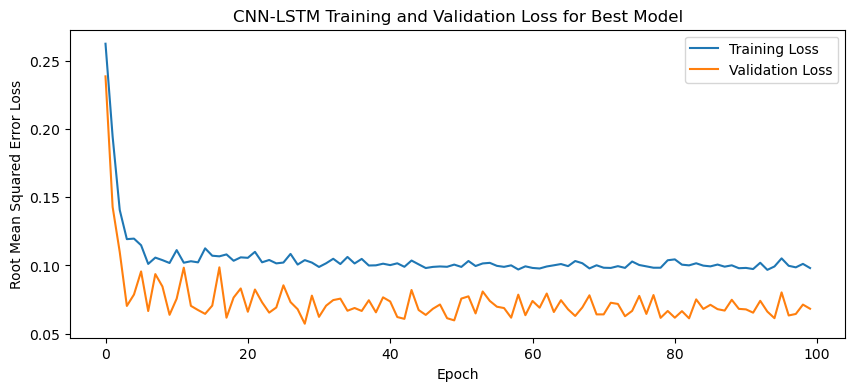

1/1 - 3s - loss: 0.1504 - 3s/epoch - 3s/step
Test Loss: 0.150433748960495
Fold 2:
Epoch 1/100
19/19 [==============================] - 23s 358ms/step - loss: 0.2948 - val_loss: 0.2002
Epoch 2/100
19/19 [==============================] - 3s 141ms/step - loss: 0.1611 - val_loss: 0.1266
Epoch 3/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1404 - val_loss: 0.0989
Epoch 4/100
19/19 [==============================] - 4s 213ms/step - loss: 0.1248 - val_loss: 0.1128
Epoch 5/100
19/19 [==============================] - 3s 173ms/step - loss: 0.1136 - val_loss: 0.0644
Epoch 6/100
19/19 [==============================] - 3s 136ms/step - loss: 0.0984 - val_loss: 0.0825
Epoch 7/100
19/19 [==============================] - 2s 121ms/step - loss: 0.1000 - val_loss: 0.0805
Epoch 8/100
19/19 [==============================] - 2s 128ms/step - loss: 0.1132 - val_loss: 0.1004
Epoch 9/100
19/19 [==============================] - 3s 149ms/step - loss: 0.1145 - val_loss: 0.0649
Epoch 10

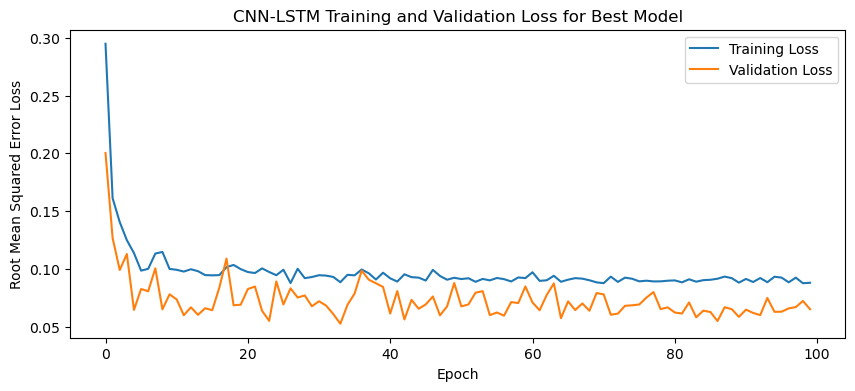

1/1 - 4s - loss: 0.0781 - 4s/epoch - 4s/step
Test Loss: 0.07811826467514038
Fold 3:
Epoch 1/100
19/19 [==============================] - 16s 277ms/step - loss: 0.2957 - val_loss: 0.1785
Epoch 2/100
19/19 [==============================] - 2s 118ms/step - loss: 0.2217 - val_loss: 0.1325
Epoch 3/100
19/19 [==============================] - 2s 129ms/step - loss: 0.1328 - val_loss: 0.0773
Epoch 4/100
19/19 [==============================] - 4s 230ms/step - loss: 0.1346 - val_loss: 0.0744
Epoch 5/100
19/19 [==============================] - 4s 203ms/step - loss: 0.1100 - val_loss: 0.0752
Epoch 6/100
19/19 [==============================] - 4s 206ms/step - loss: 0.1029 - val_loss: 0.0984
Epoch 7/100
19/19 [==============================] - 3s 143ms/step - loss: 0.1022 - val_loss: 0.0840
Epoch 8/100
19/19 [==============================] - 5s 258ms/step - loss: 0.1080 - val_loss: 0.0619
Epoch 9/100
19/19 [==============================] - 3s 134ms/step - loss: 0.1005 - val_loss: 0.0795
Epoch 

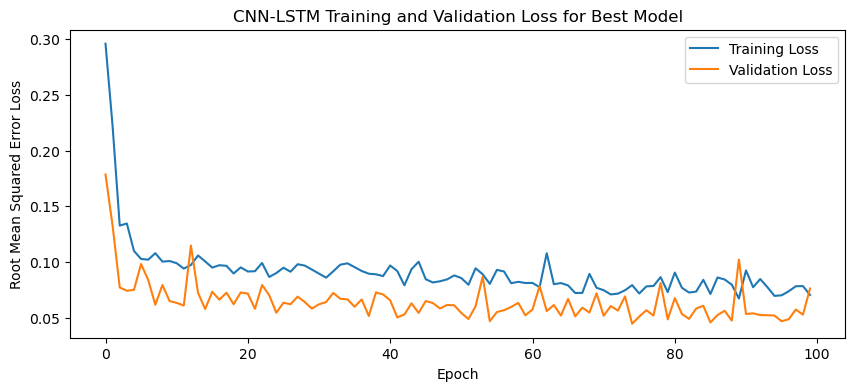

1/1 - 4s - loss: 0.0629 - 4s/epoch - 4s/step
Test Loss: 0.06293381005525589
Fold 4:
Epoch 1/100
20/20 [==============================] - 20s 374ms/step - loss: 0.2477 - val_loss: 0.2613
Epoch 2/100
20/20 [==============================] - 3s 165ms/step - loss: 0.1943 - val_loss: 0.3443
Epoch 3/100
20/20 [==============================] - 3s 161ms/step - loss: 0.1567 - val_loss: 0.1786
Epoch 4/100
20/20 [==============================] - 3s 148ms/step - loss: 0.1258 - val_loss: 0.1590
Epoch 5/100
20/20 [==============================] - 3s 151ms/step - loss: 0.1230 - val_loss: 0.1578
Epoch 6/100
20/20 [==============================] - 3s 145ms/step - loss: 0.1064 - val_loss: 0.1300
Epoch 7/100
20/20 [==============================] - 4s 181ms/step - loss: 0.0960 - val_loss: 0.1736
Epoch 8/100
20/20 [==============================] - 3s 161ms/step - loss: 0.0941 - val_loss: 0.1760
Epoch 9/100
20/20 [==============================] - 3s 149ms/step - loss: 0.0894 - val_loss: 0.1281
Epoch 

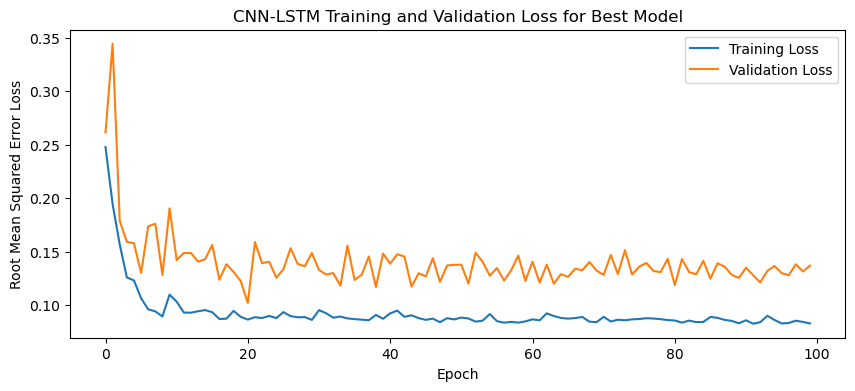

1/1 - 3s - loss: 0.0803 - 3s/epoch - 3s/step
Test Loss: 0.08030624687671661
Fold 5:
Epoch 1/100
19/19 [==============================] - 21s 365ms/step - loss: 0.2461 - val_loss: 0.2342
Epoch 2/100
19/19 [==============================] - 3s 137ms/step - loss: 0.1572 - val_loss: 0.2462
Epoch 3/100
19/19 [==============================] - 3s 141ms/step - loss: 0.1430 - val_loss: 0.2034
Epoch 4/100
19/19 [==============================] - 3s 177ms/step - loss: 0.1377 - val_loss: 0.1780
Epoch 5/100
19/19 [==============================] - 3s 148ms/step - loss: 0.1079 - val_loss: 0.2103
Epoch 6/100
19/19 [==============================] - 3s 163ms/step - loss: 0.1024 - val_loss: 0.1479
Epoch 7/100
19/19 [==============================] - 3s 148ms/step - loss: 0.0986 - val_loss: 0.1718
Epoch 8/100
19/19 [==============================] - 3s 156ms/step - loss: 0.0972 - val_loss: 0.1776
Epoch 9/100
19/19 [==============================] - 4s 185ms/step - loss: 0.1031 - val_loss: 0.2022
Epoch 

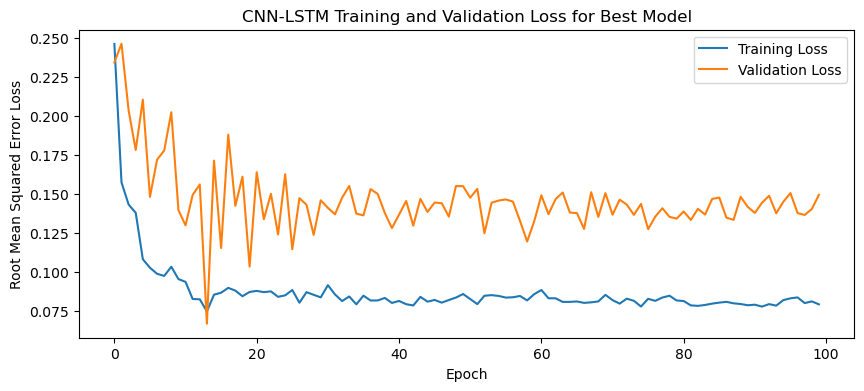

1/1 - 4s - loss: 0.0928 - 4s/epoch - 4s/step
Test Loss: 0.09277581423521042


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

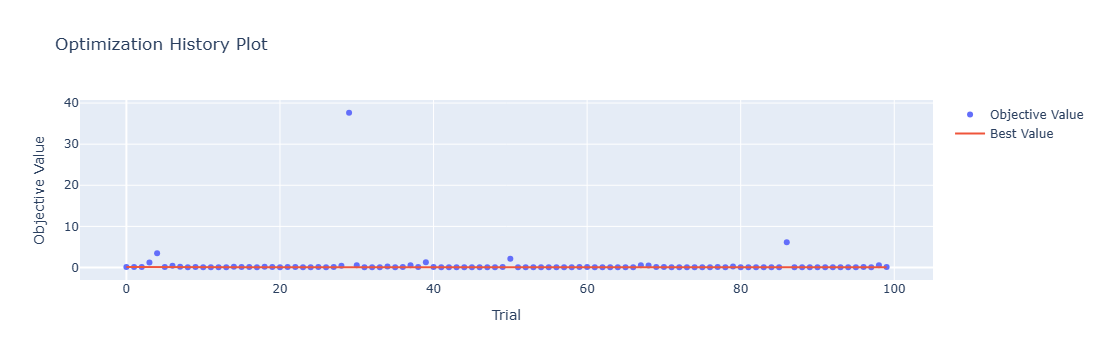

In [4]:
optuna.visualization.plot_optimization_history(study)

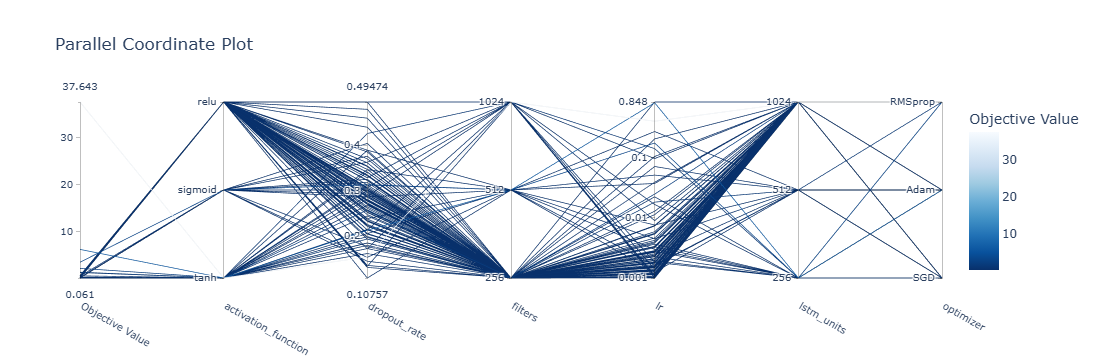

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

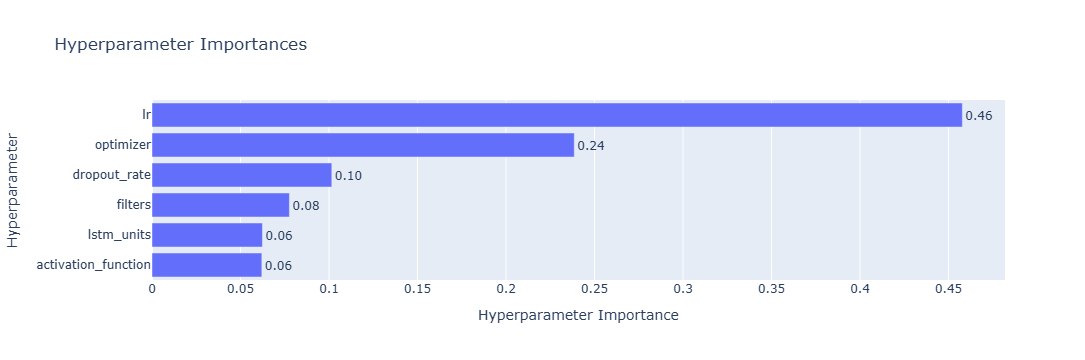

In [6]:
optuna.visualization.plot_param_importances(study)

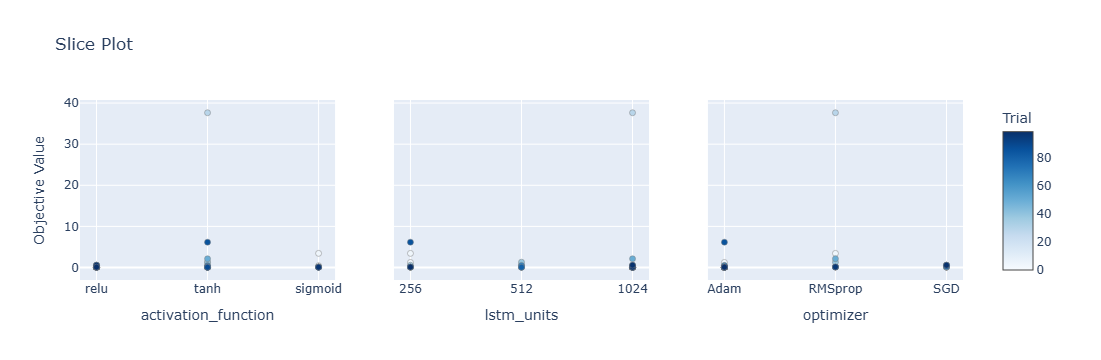

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

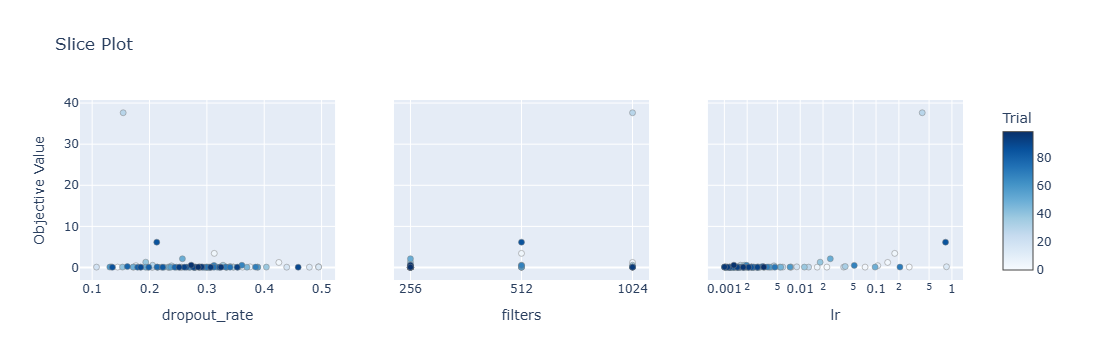

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 23s 426ms/step - loss: 0.2619 - accuracy: 0.1579 - mae: 0.2237 - rmse: 0.2619 - mape: 39.5631 - pearson: 0.3128 - val_loss: 0.2012 - val_accuracy: 0.3333 - val_mae: 0.1913 - val_rmse: 0.2012 - val_mape: 34.6970 - val_pearson: 0.1205
Epoch 2/100
19/19 [==============================] - 2s 102ms/step - loss: 0.1616 - accuracy: 0.5263 - mae: 0.1335 - rmse: 0.1616 - mape: 23.9350 - pearson: 0.3804 - val_loss: 0.1536 - val_accuracy: 0.3333 - val_mae: 0.1239 - val_rmse: 0.1536 - val_mape: 22.3622 - val_pearson: 0.2962
Epoch 3/100
19/19 [==============================] - 2s 95ms/step - loss: 0.1635 - accurac

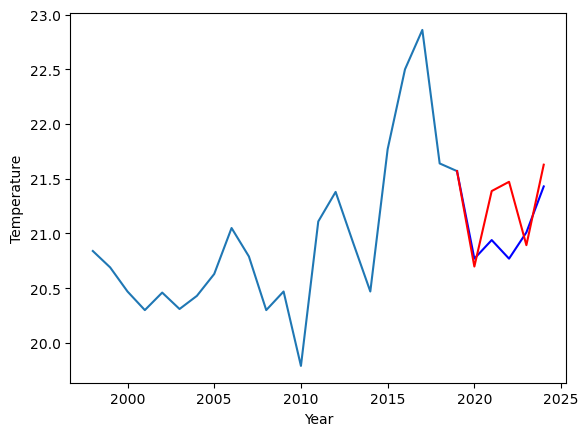

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.43		-1.09
16.69		17.12		0.43
16.18		17.20		1.02
16.46		16.62		0.16
16.29		17.36		1.07


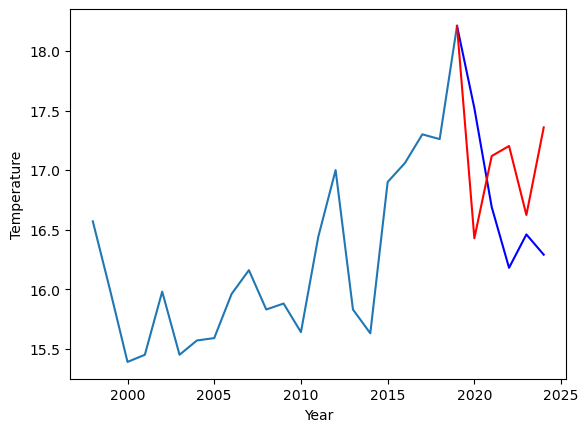

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.698094
1                1   17.52  16.428087


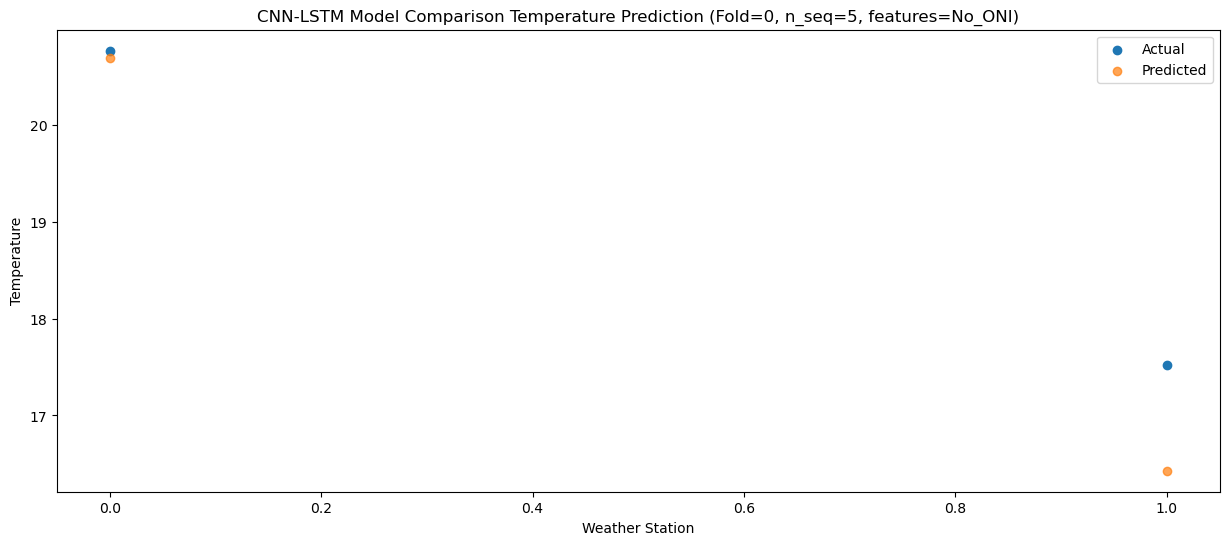

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.387834
1                1   16.69  17.117809


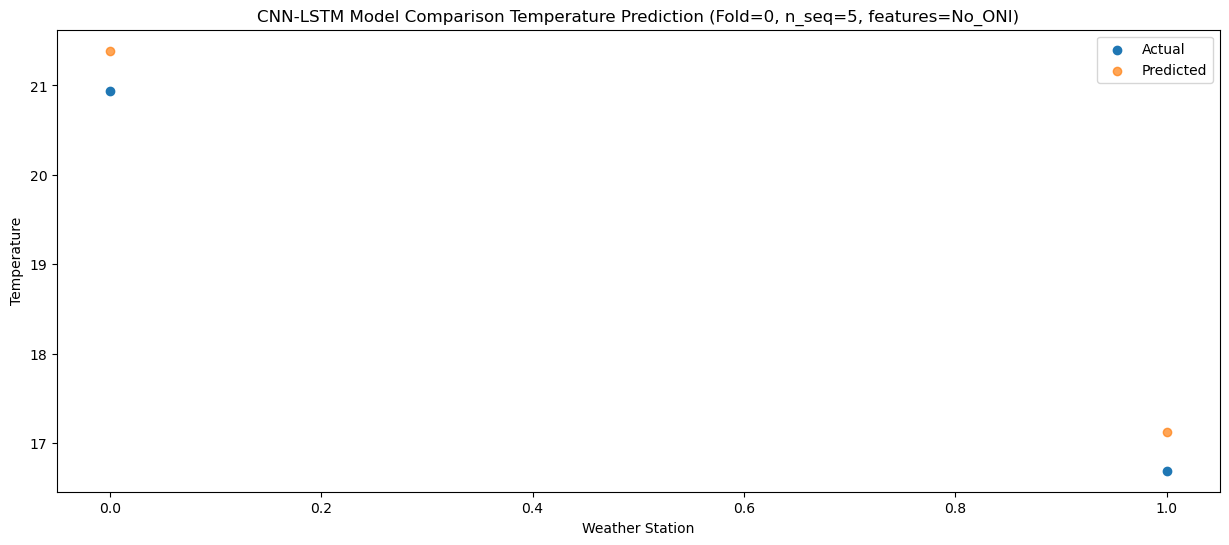

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.472296
1                1   16.18  17.202264


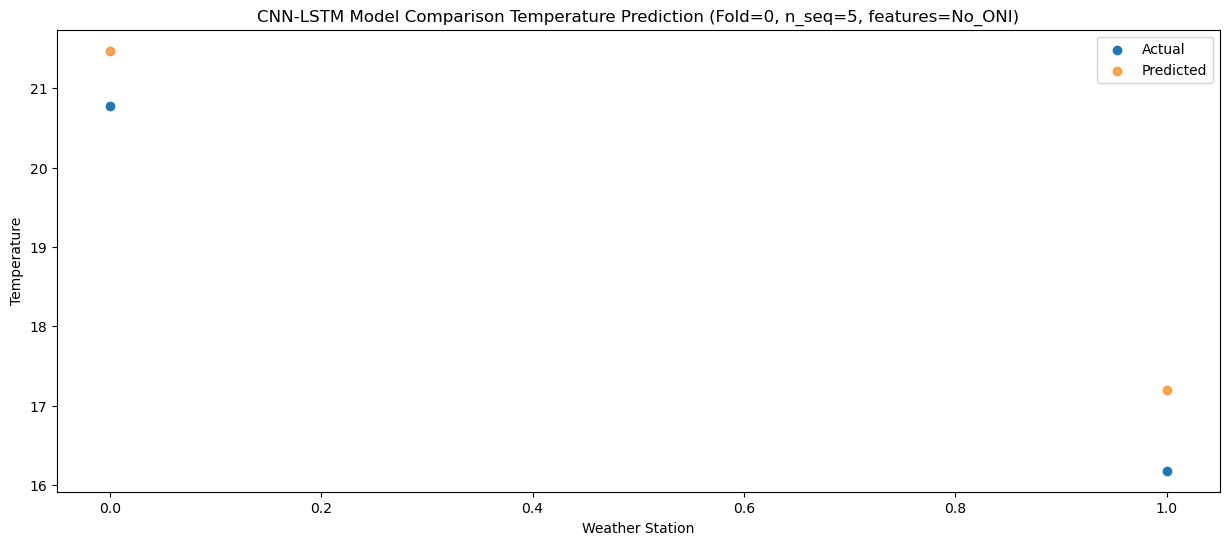

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  20.893372
1                1   16.46  16.623341


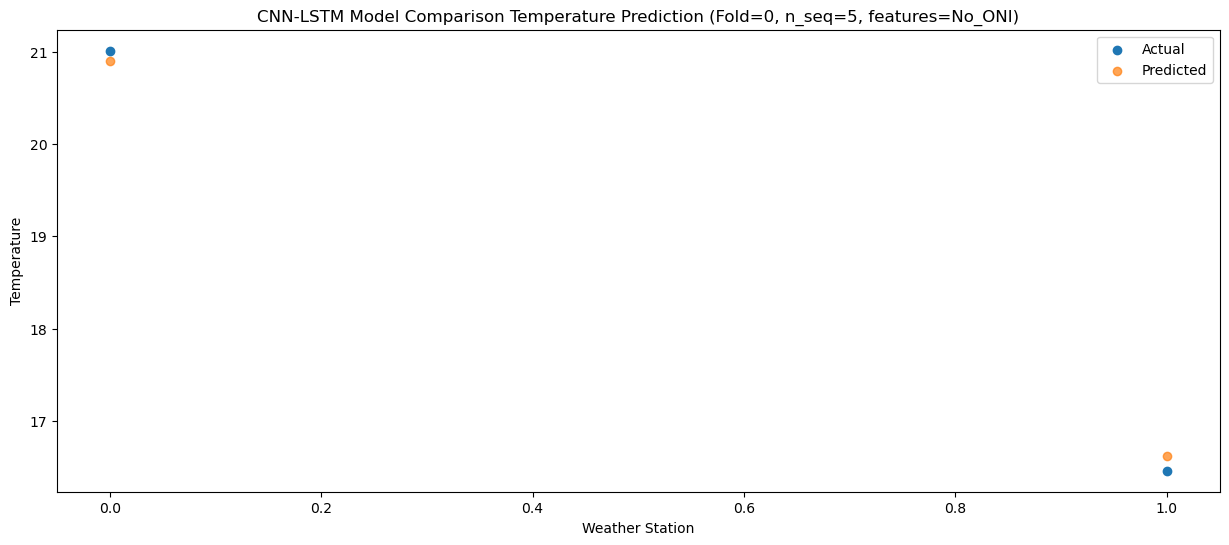

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  21.628690
1                1   16.29  17.358651


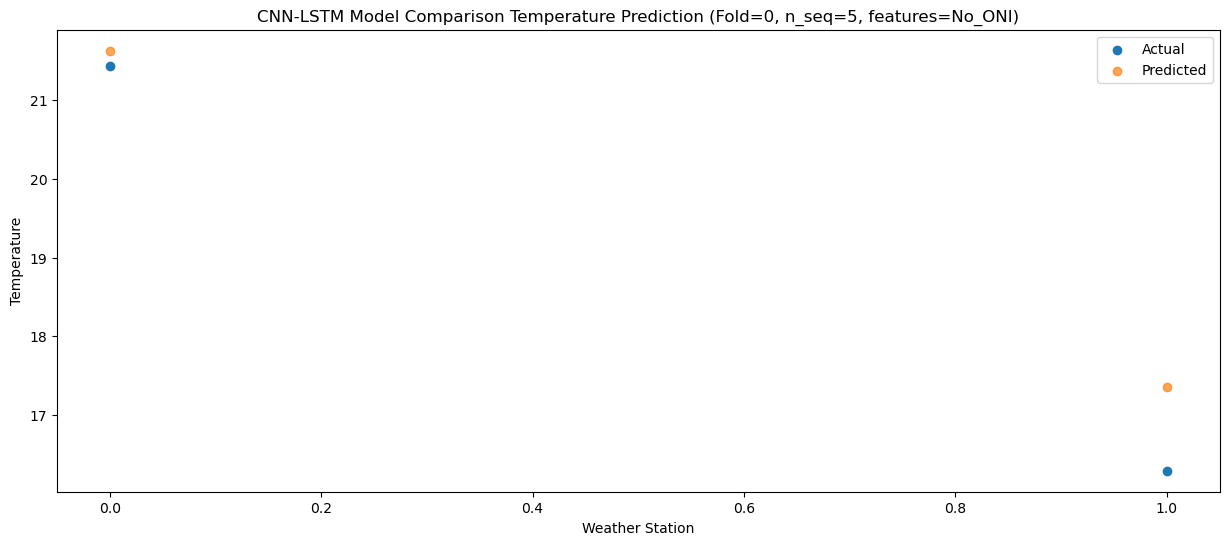

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.69809392 16.42808662]
 [21.38783398 17.1178088 ]
 [21.47229568 17.20226393]
 [20.89337209 16.6233407 ]
 [21.62868998 17.3586506 ]]
Year at t+1:
t+1 SKRMSE: 0.773772
t+1 KRMSE: 0.773772
t+1 MAE: 0.581910
t+1 SKMAPE: 0.032893
t+1 R2_SCORE: 0.773265
t+1 KMAPE: 0.032893
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.437936
t+2 KRMSE: 0.437936
t+2 MAE: 0.437821
t+2 SKMAPE: 0.023510
t+2 R2_SCORE: 0.957528
t+2 KMAPE: 0.023510
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.876996
t+3 KRMSE: 0.876996
t+3 MAE: 0.862280
t+3 SKMAPE: 0.048497
t+3 R2_SCORE: 0.853974
t+3 KMAPE: 0.048497
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.141919
t+4 KRMSE: 0.141919
t+4 MAE: 0.139984
t+4 SKMAPE: 0.007737
t+4 R2_SCORE: 0.996108
t+4 KMAPE: 0.007737
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.768600
t+5 KRMSE: 0.768600
t+5 MAE: 0.633670
t+5 SKMAPE: 0.037437
t+5 R2_SCORE: 0.910559
t+5 KMAPE: 0.037437
t+5 PEARSON: 1

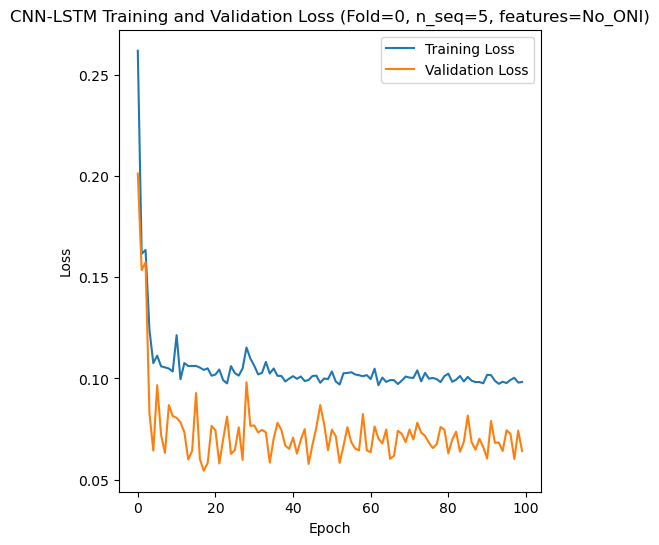

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 26s 422ms/step - loss: 0.2880 - accuracy: 0.3158 - mae: 0.2519 - rmse: 0.2880 - mape: 39.8877 - pearson: 0.3080 - val_loss: 0.1835 - val_accuracy: 0.0000e+00 - val_mae: 0.1602 - val_rmse: 0.1835 - val_mape: 25.6794 - val_pearson: 0.3526
Epoch 2/100
19/19 [==============================] - 2s 101ms/step - loss: 0.2287 - accuracy: 0.5263 - mae: 0.1984 - rmse: 0.2287 - mape: 31.7613 - pearson: 0.3299 - val_loss: 0.0682 - val_accuracy: 1.0000 - val_mae: 0.0598 - val_rmse: 0.0682 - val_mape: 9.5974 - val_pearson: 0.6374
Epoch 3/100
19/19 [==============================] - 2s 97ms/step - loss: 0.1368 - accur

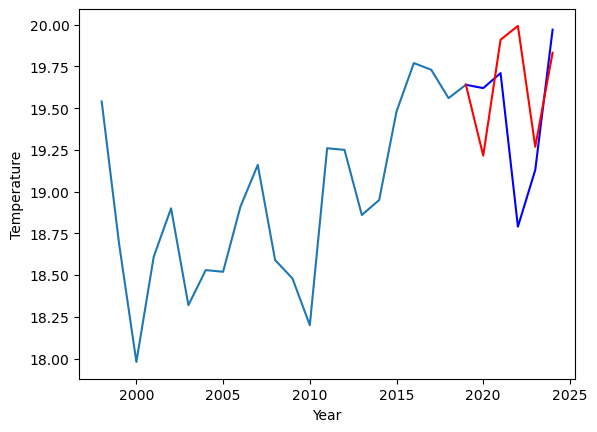

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		19.37		-0.45
20.34		20.06		-0.28
19.95		20.14		0.19
19.95		19.42		-0.53
21.26		19.98		-1.28


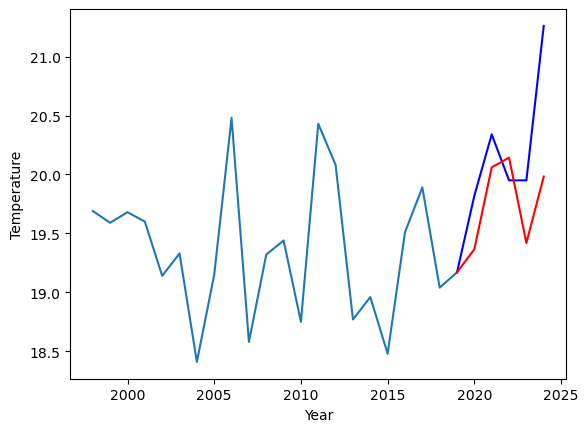

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  19.215705
1                1   19.82  19.365775


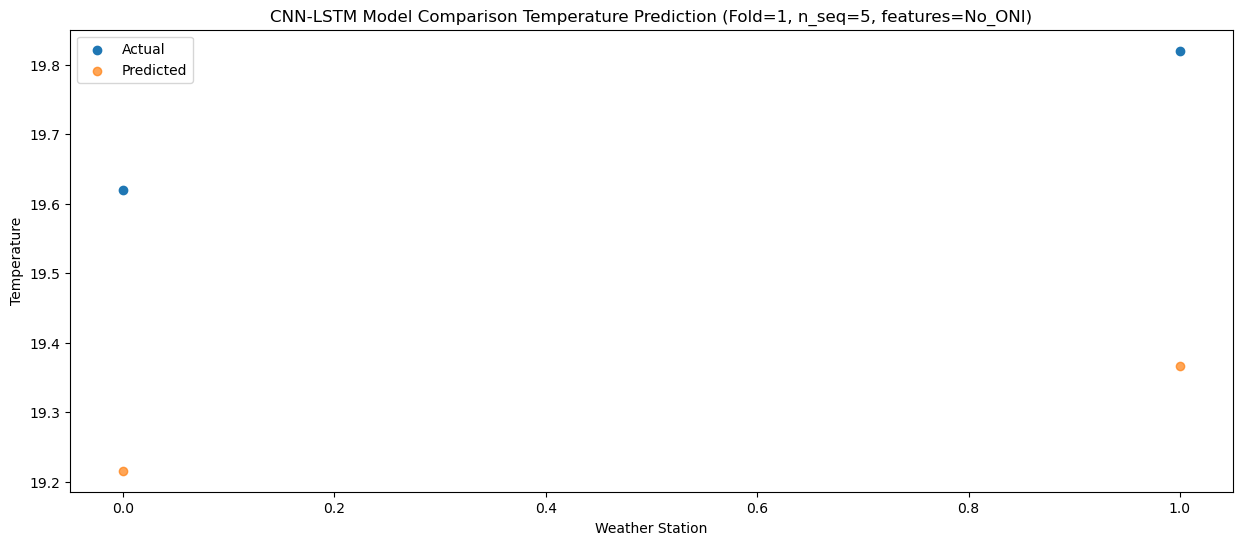

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  19.909945
1                1   20.34  20.060185


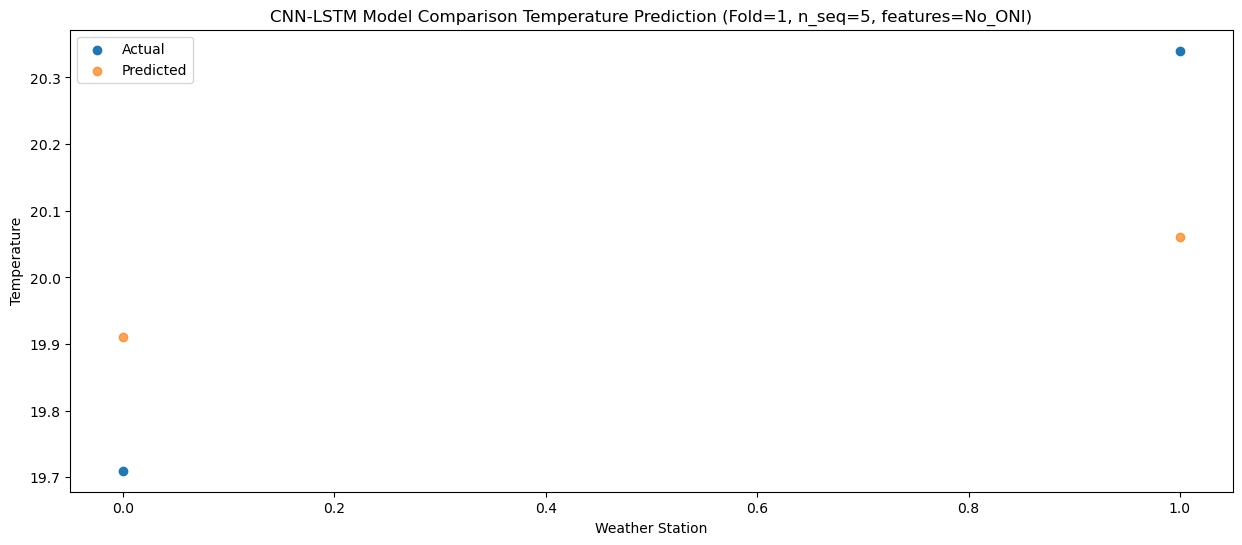

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  19.992532
1                1   19.95  20.142723


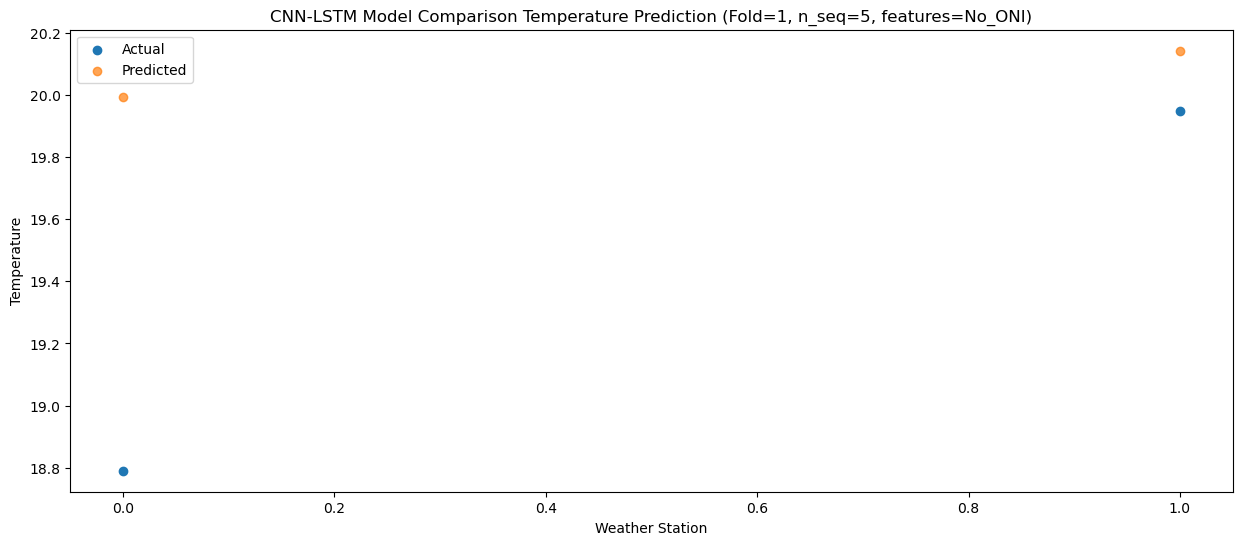

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.268544
1                1   19.95  19.418702


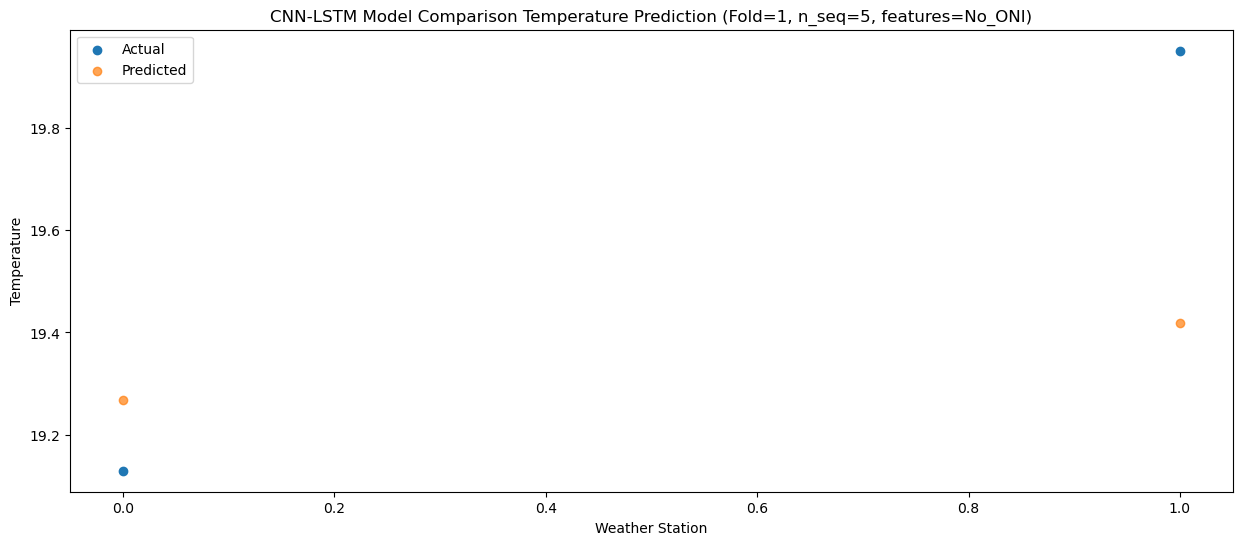

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  19.832059
1                1   21.26  19.982067


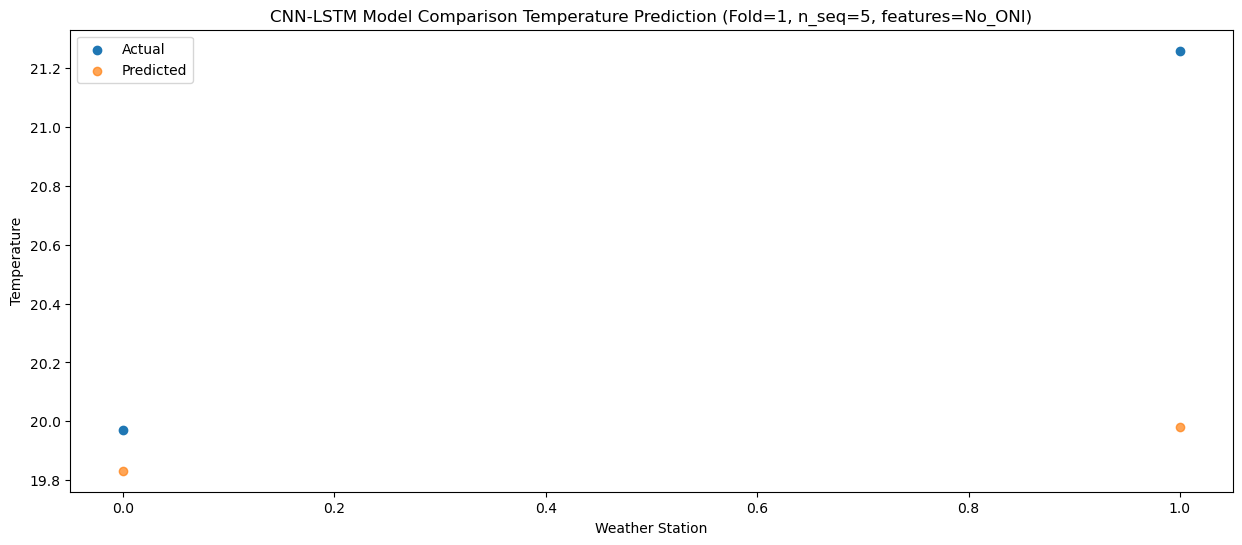

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[19.21570528 19.36577496]
 [19.90994454 20.06018499]
 [19.99253159 20.14272253]
 [19.26854401 19.41870181]
 [19.83205884 19.98206721]]
Year at t+1:
t+1 SKRMSE: 0.429985
t+1 KRMSE: 0.429985
t+1 MAE: 0.429260
t+1 SKMAPE: 0.021762
t+1 R2_SCORE: -17.488730
t+1 KMAPE: 0.021762
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.243181
t+2 KRMSE: 0.243181
t+2 MAE: 0.239880
t+2 SKMAPE: 0.011951
t+2 R2_SCORE: 0.404010
t+2 KMAPE: 0.011951
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.861169
t+3 KRMSE: 0.861169
t+3 MAE: 0.697627
t+3 SKMAPE: 0.036829
t+3 R2_SCORE: -1.204554
t+3 KMAPE: 0.036829
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.388247
t+4 KRMSE: 0.388247
t+4 MAE: 0.334921
t+4 SKMAPE: 0.016937
t+4 R2_SCORE: 0.103295
t+4 KMAPE: 0.016937
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.908884
t+5 KRMSE: 0.908884
t+5 MAE: 0.707937
t+5 SKMAPE: 0.033509
t+5 R2_SCORE: -0.985626
t+5 KMAPE: 0.033509
t+5 PEARSO

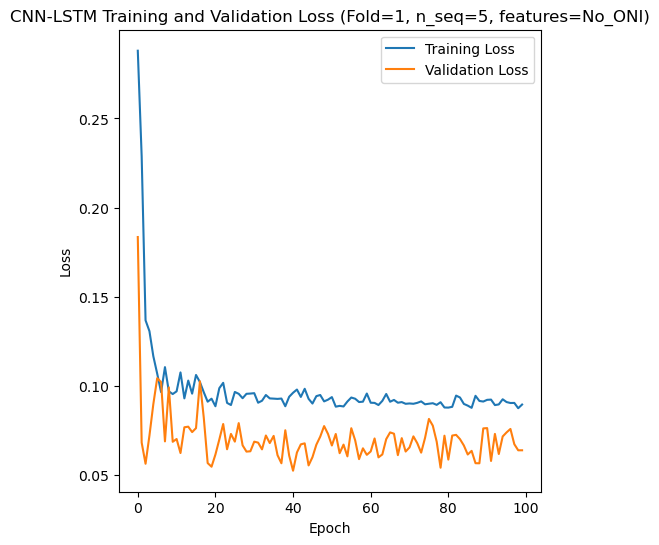

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 20s 355ms/step - loss: 0.3453 - accuracy: 0.2632 - mae: 0.3054 - rmse: 0.3453 - mape: 48.4843 - pearson: 0.4367 - val_loss: 0.1164 - val_accuracy: 0.6667 - val_mae: 0.0965 - val_rmse: 0.1164 - val_mape: 15.5350 - val_pearson: 0.4680
Epoch 2/100
19/19 [==============================] - 1s 65ms/step - loss: 0.1730 - accuracy: 0.3684 - mae: 0.1473 - rmse: 0.1730 - mape: 24.0943 - pearson: 0.4380 - val_loss: 0.1638 - val_accuracy: 0.6667 - val_mae: 0.1459 - val_rmse: 0.1638 - val_mape: 23.3362 - val_pearson: 0.5768
Epoch 3/100
19/19 [==============================] - 1s 67ms/step - loss: 0.2103 - accuracy:

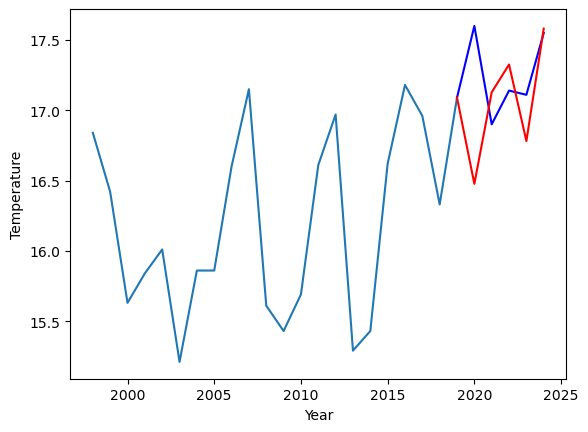

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.15		-0.69
13.83		13.80		-0.03
13.82		14.00		0.18
13.36		13.45		0.09
14.15		14.25		0.10


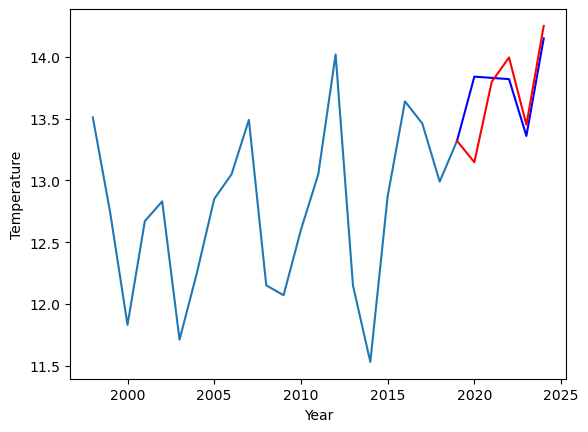

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  16.476736
1                1   13.84  13.146736


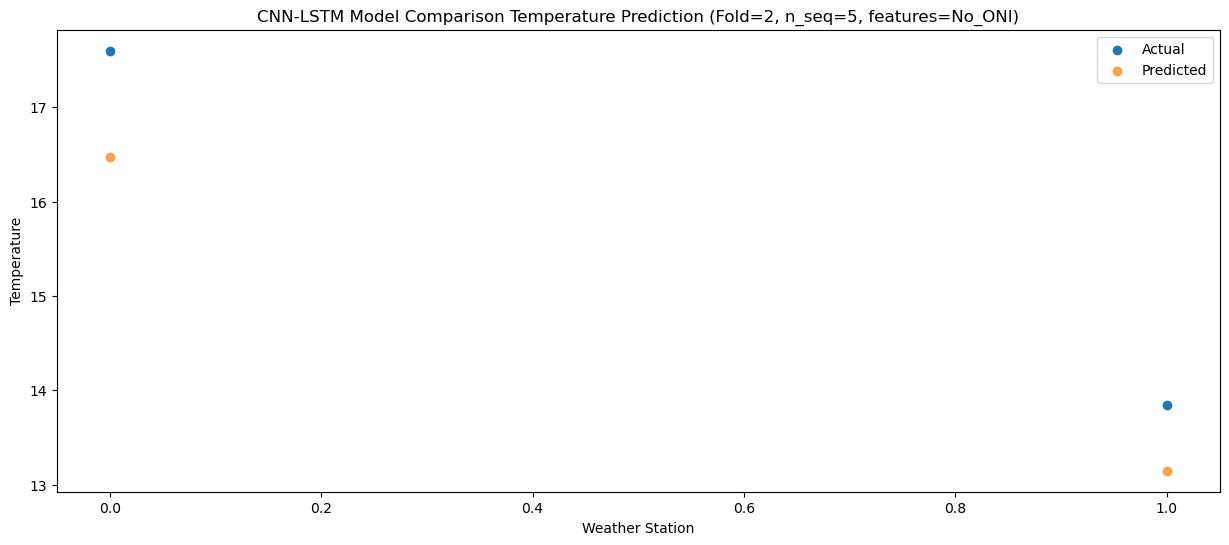

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.128093
1                1   13.83  13.798093


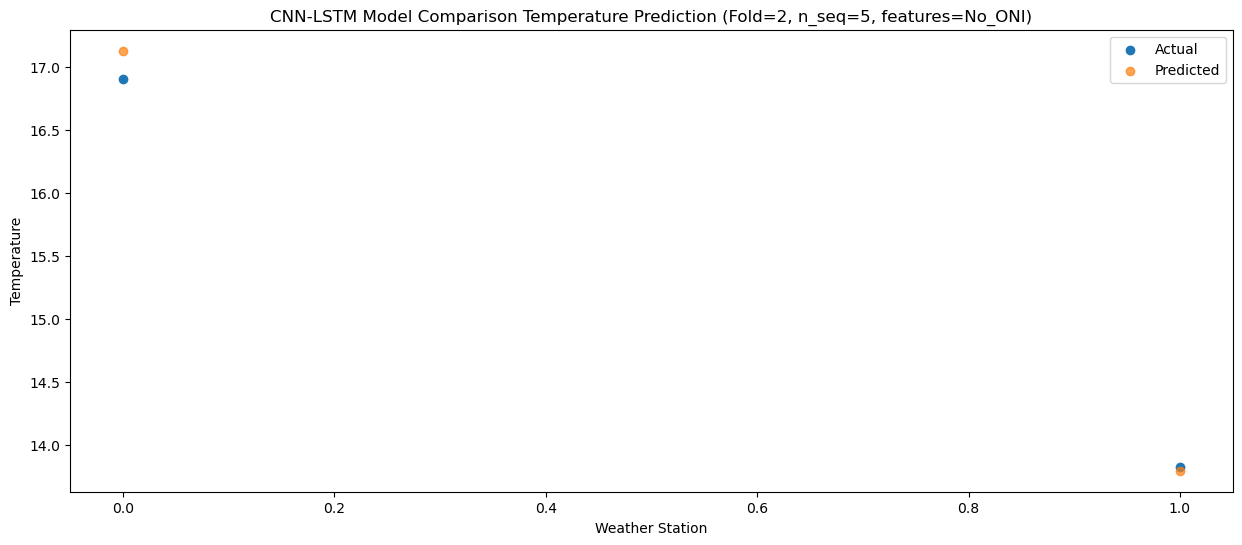

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14    17.3254
1                1   13.82    13.9954


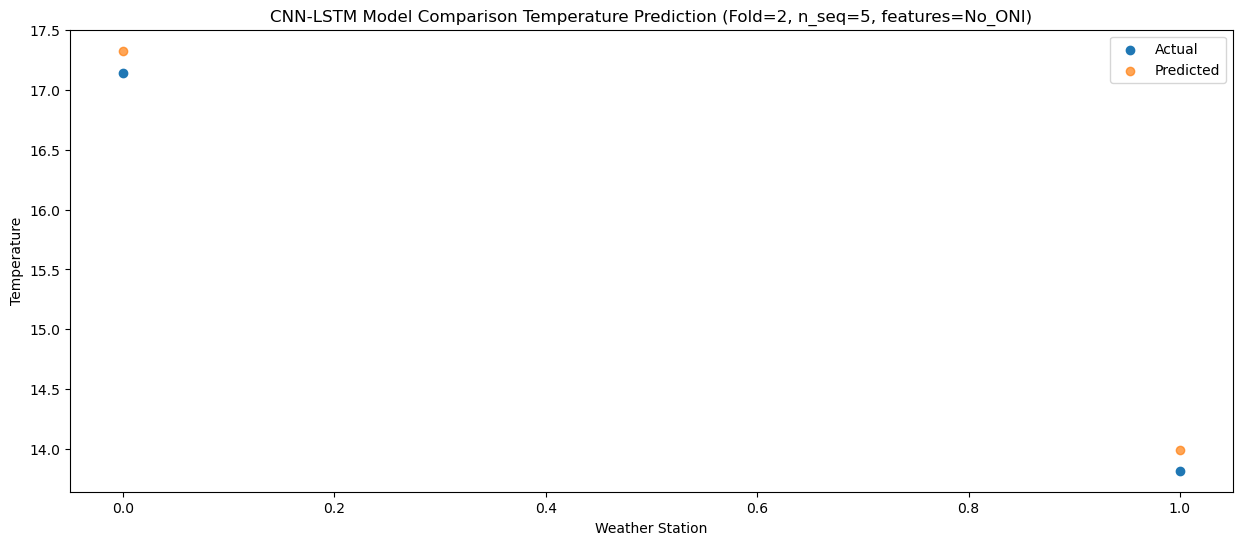

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.780664
1                1   13.36  13.450664


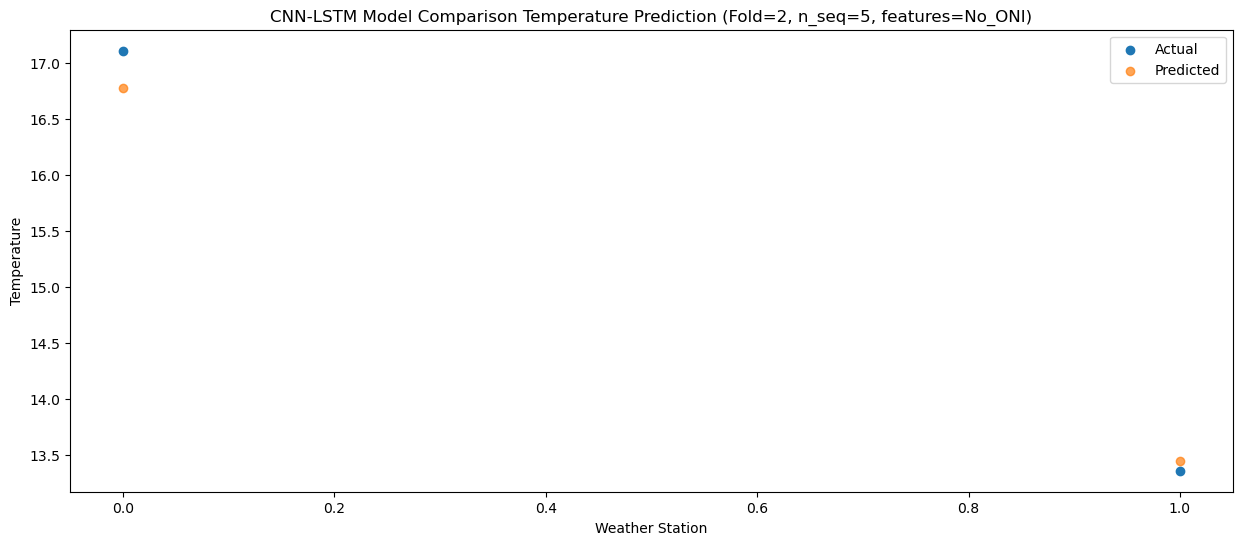

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  17.580771
1                1   14.15  14.250771


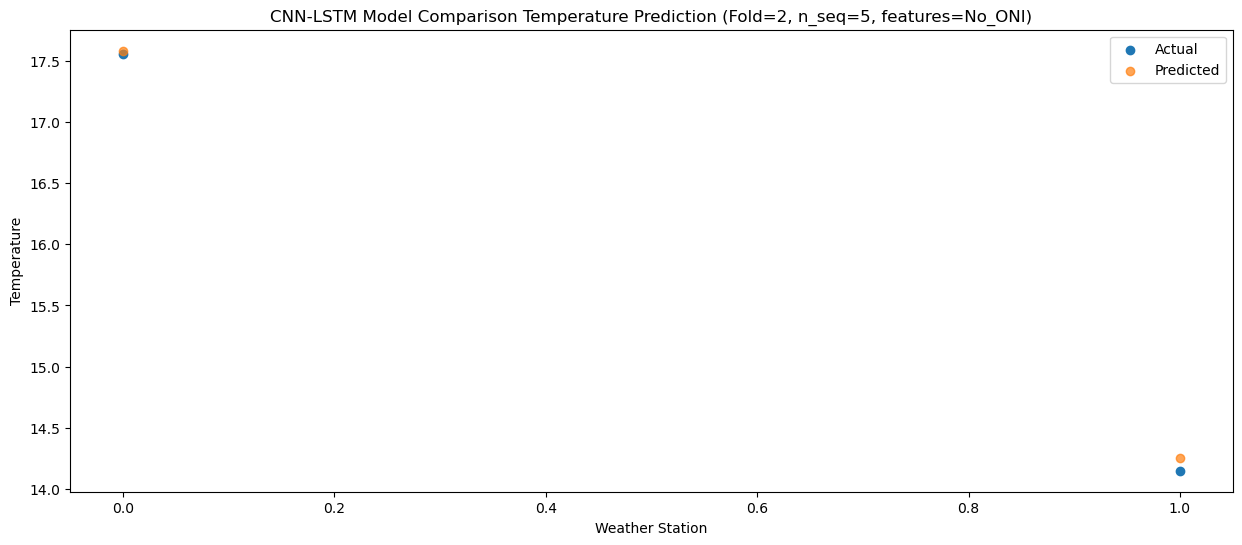

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[16.47673592 13.14673592]
 [17.12809285 13.79809285]
 [17.32539975 13.99539975]
 [16.78066361 13.45066361]
 [17.58077132 14.25077132]]
Year at t+1:
t+1 SKRMSE: 0.933364
t+1 KRMSE: 0.933364
t+1 MAE: 0.908264
t+1 SKMAPE: 0.056957
t+1 R2_SCORE: 0.753517
t+1 KMAPE: 0.056957
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.162856
t+2 KRMSE: 0.162856
t+2 MAE: 0.130000
t+2 SKMAPE: 0.007902
t+2 R2_SCORE: 0.988744
t+2 KMAPE: 0.007902
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.180469
t+3 KRMSE: 0.180469
t+3 MAE: 0.180400
t+3 SKMAPE: 0.011754
t+3 R2_SCORE: 0.988181
t+3 KMAPE: 0.011754
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.241539
t+4 KRMSE: 0.241539
t+4 MAE: 0.210000
t+4 SKMAPE: 0.013017
t+4 R2_SCORE: 0.983405
t+4 KMAPE: 0.013017
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.074504
t+5 KRMSE: 0.074504
t+5 MAE: 0.065771
t+5 SKMAPE: 0.004438
t+5 R2_SCORE: 0.998079
t+5 KMAPE: 0.004438
t+5 PEARSON: 1

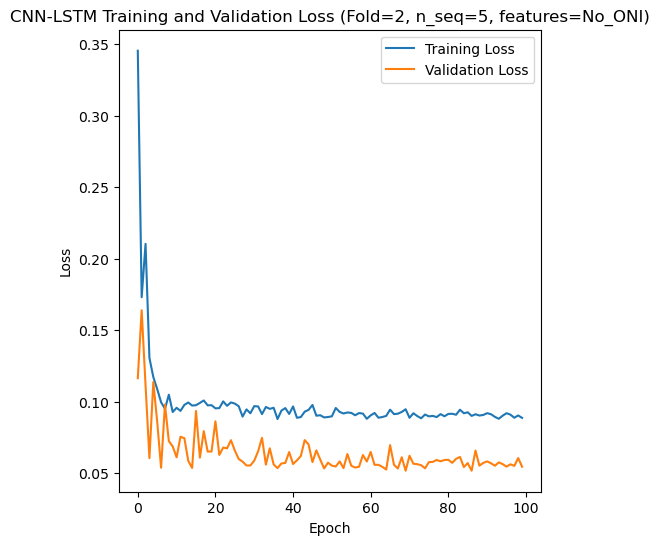

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 14s 164ms/step - loss: 0.2816 - accuracy: 0.2000 - mae: 0.2468 - rmse: 0.2816 - mape: 37.5146 - pearson: 0.3232 - val_loss: 0.2985 - val_accuracy: 0.5000 - val_mae: 0.2567 - val_rmse: 0.2985 - val_mape: 35.9424 - val_pearson: 0.4250
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 0.2031 - accuracy: 0.2000 - mae: 0.1767 - rmse: 0.2031 - mape: 28.7904 - pearson: 0.3065 - val_loss: 0.2132 - val_accuracy: 0.5000 - val_mae: 0.1924 - val_rmse: 0.2132 - val_mape: 28.8211 - val_pearson: 0.1518
Epoch 3/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1296 - accuracy: 

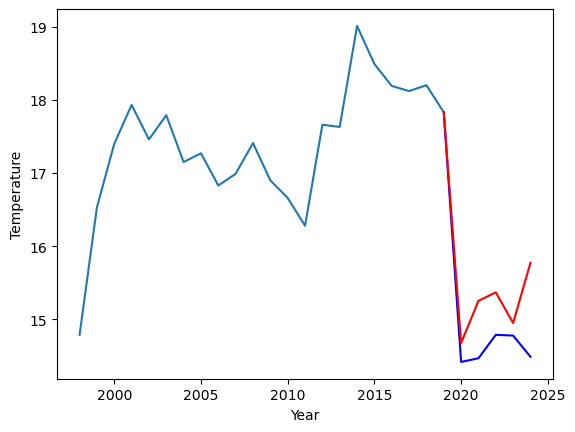

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		13.95		-0.52
14.35		14.52		0.17
14.15		14.64		0.49
13.85		14.22		0.37
14.87		15.04		0.17


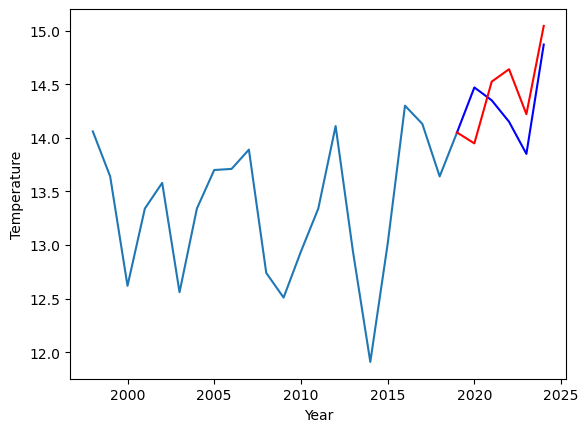

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.678307
1                1   14.47  13.947929


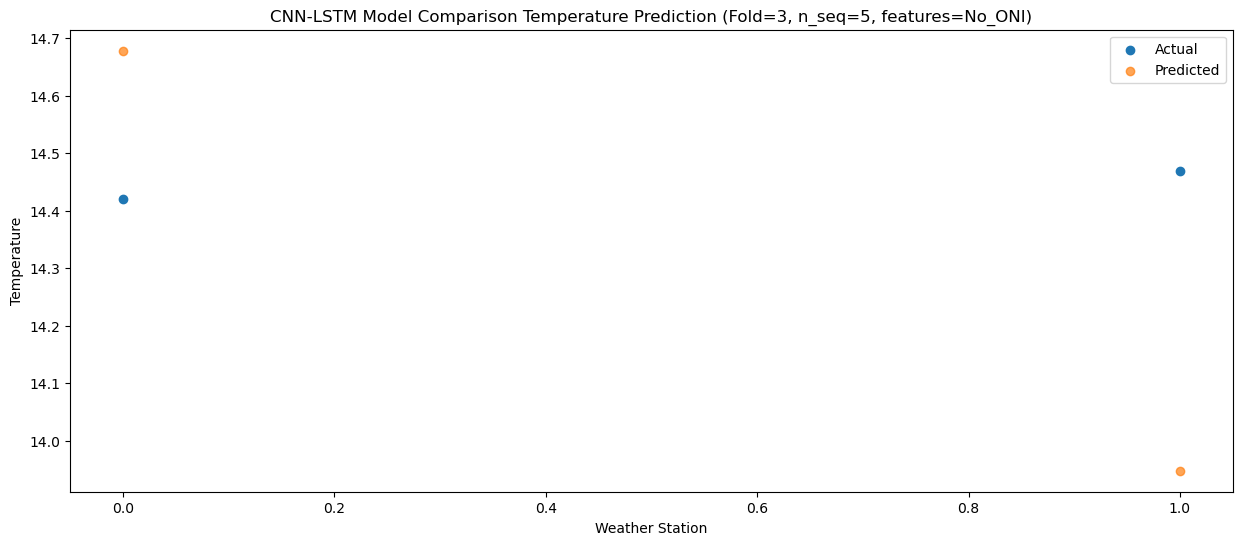

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.254653
1                1   14.35  14.524054


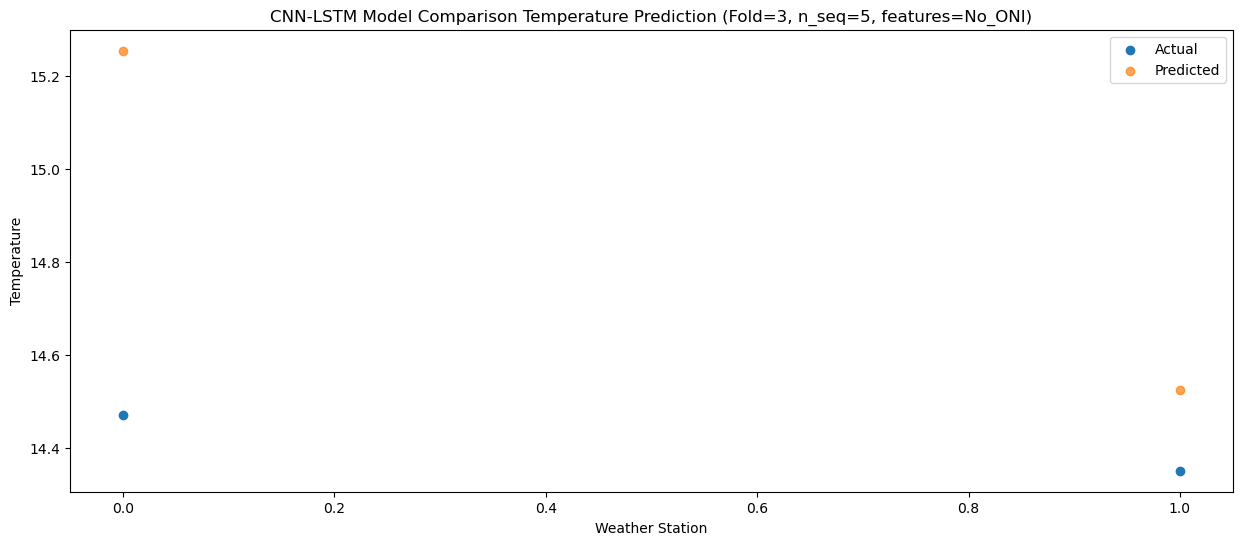

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  15.370287
1                1   14.15  14.639986


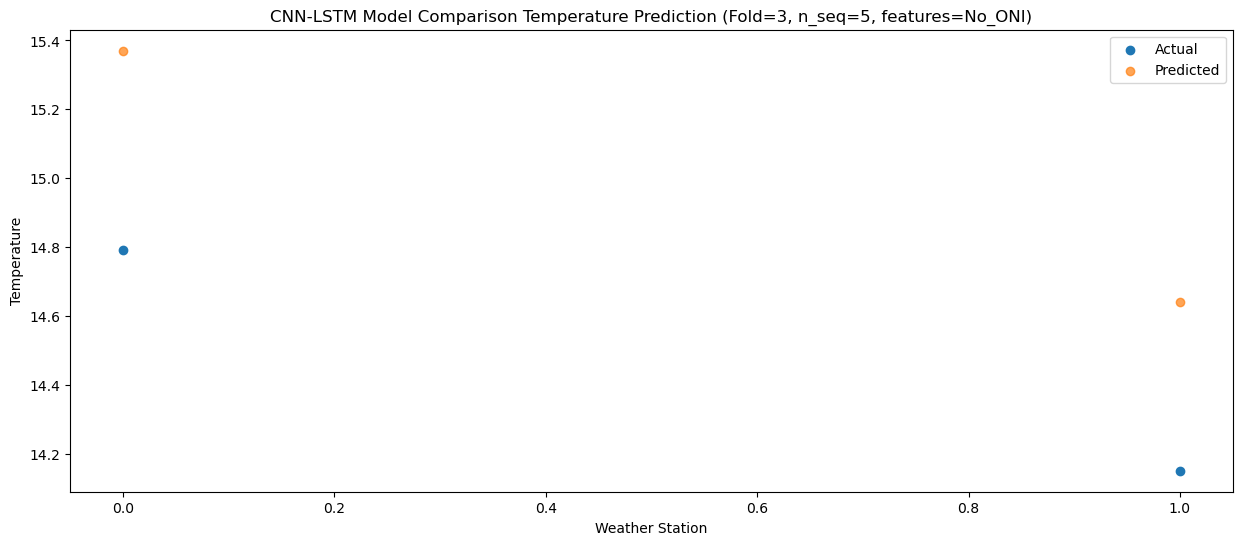

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  14.951448
1                1   13.85  14.220717


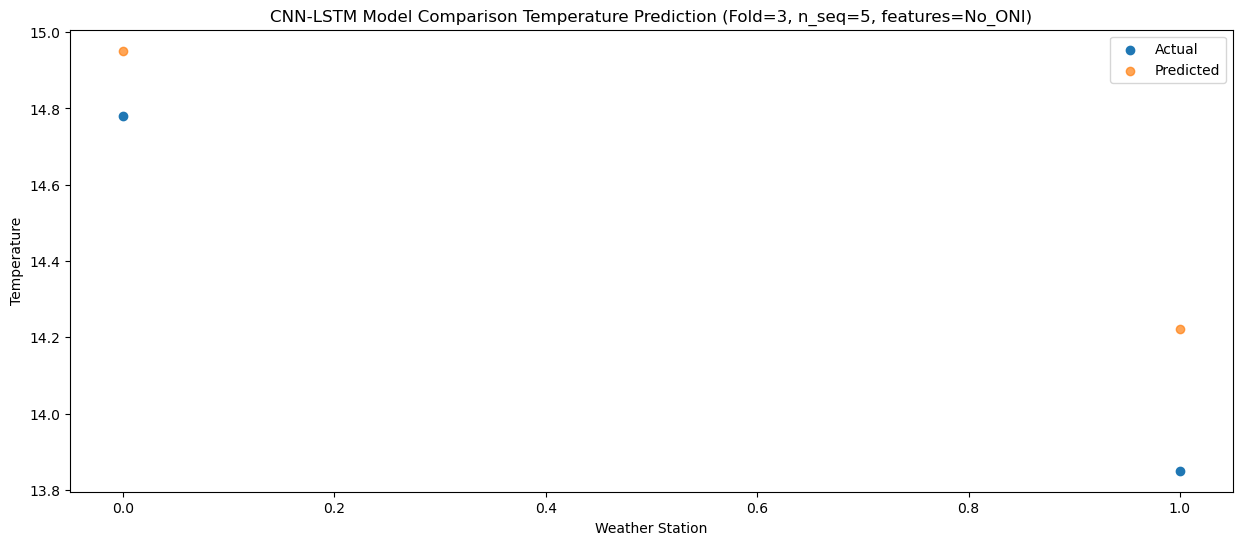

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  15.774927
1                1   14.87  15.043727


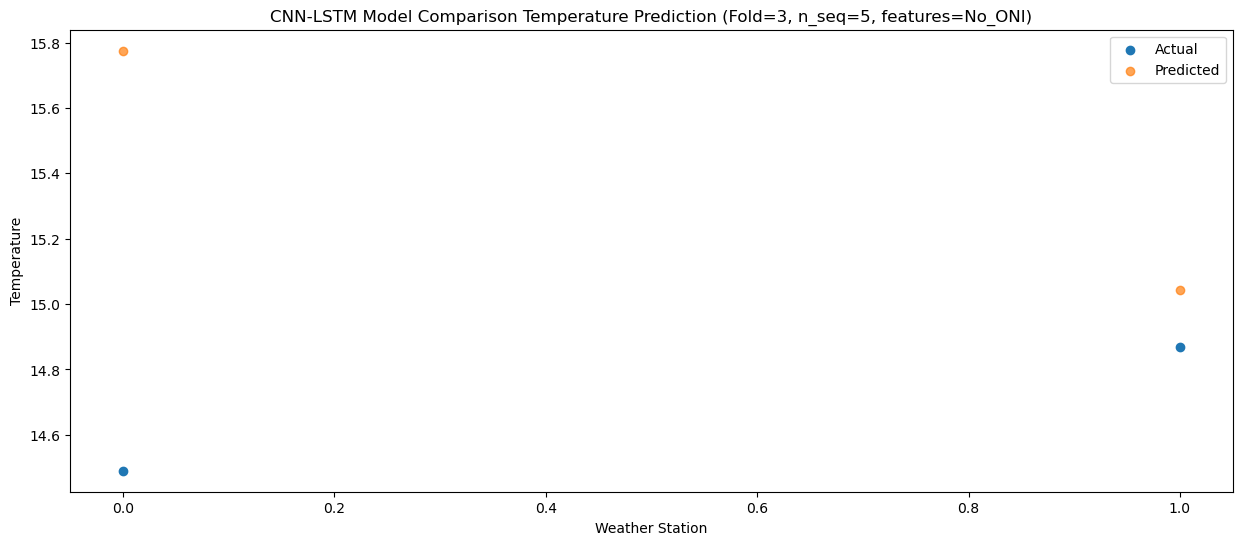

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.67830697 13.94792881]
 [15.25465348 14.52405402]
 [15.37028716 14.639986  ]
 [14.95144779 14.22071742]
 [15.77492655 15.04372721]]
Year at t+1:
t+1 SKRMSE: 0.411874
t+1 KRMSE: 0.411874
t+1 MAE: 0.390189
t+1 SKMAPE: 0.026996
t+1 R2_SCORE: -270.424651
t+1 KMAPE: 0.026996
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.568320
t+2 KRMSE: 0.568320
t+2 MAE: 0.479354
t+2 SKMAPE: 0.033178
t+2 R2_SCORE: -88.718874
t+2 KMAPE: 0.033178
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.537038
t+3 KRMSE: 0.537038
t+3 MAE: 0.535137
t+3 SKMAPE: 0.036932
t+3 R2_SCORE: -1.816501
t+3 KMAPE: 0.036932
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.288813
t+4 KRMSE: 0.288813
t+4 MAE: 0.271083
t+4 SKMAPE: 0.019183
t+4 R2_SCORE: 0.614231
t+4 KMAPE: 0.019183
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.916847
t+5 KRMSE: 0.916847
t+5 MAE: 0.729327
t+5 SKMAPE: 0.050180
t+5 R2_SCORE: -22.285559
t+5 KMAPE: 0.050180
t+5 PE

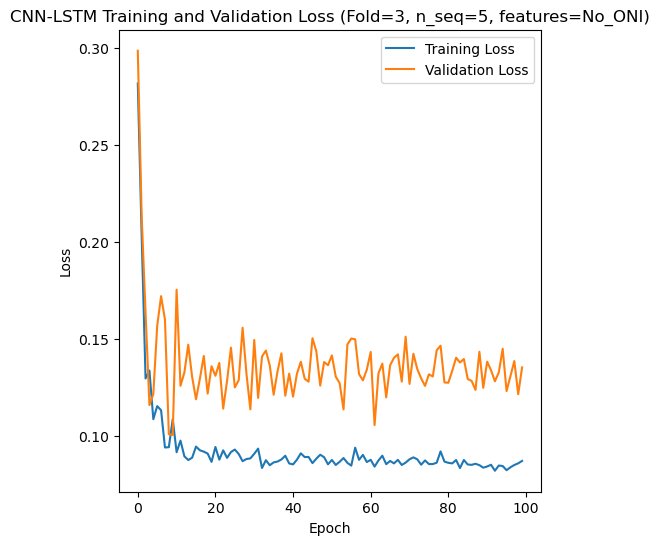

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 14s 199ms/step - loss: 0.2191 - accuracy: 0.3158 - mae: 0.1911 - rmse: 0.2191 - mape: 29.5661 - pearson: 0.2854 - val_loss: 0.2836 - val_accuracy: 0.0000e+00 - val_mae: 0.2544 - val_rmse: 0.2836 - val_mape: 49.7542 - val_pearson: 0.5783
Epoch 2/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1773 - accuracy: 0.3684 - mae: 0.1572 - rmse: 0.1773 - mape: 25.0654 - pearson: 0.3136 - val_loss: 0.1857 - val_accuracy: 0.0000e+00 - val_mae: 0.1752 - val_rmse: 0.1857 - val_mape: 30.4399 - val_pearson: 0.3231
Epoch 3/100
19/19 [==============================] - 1s 45ms/step - loss: 0.1549 - 

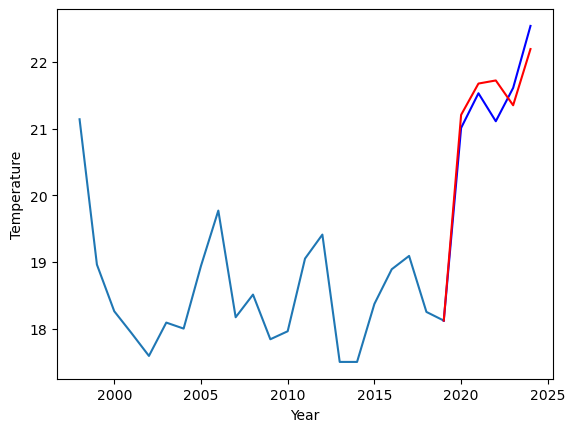

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		13.00		0.77
12.79		13.47		0.68
13.11		13.51		0.40
12.24		13.14		0.90
13.72		13.98		0.26


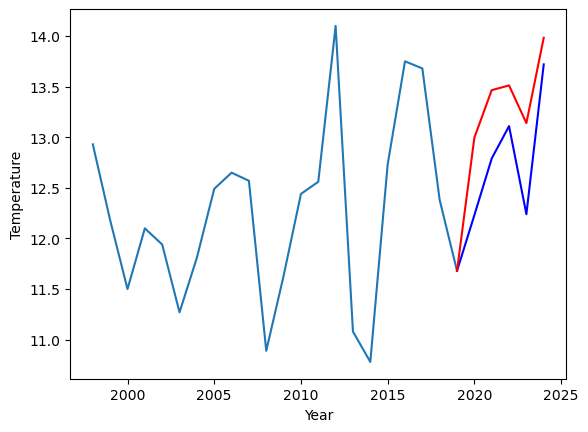

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  21.205484
1                1   12.23  12.995484


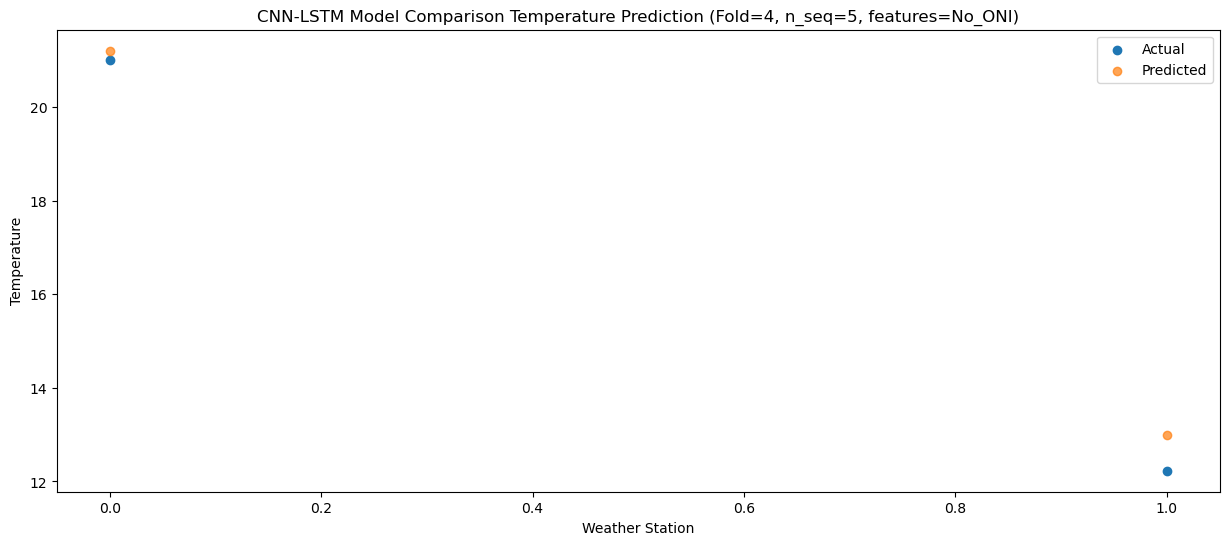

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.675463
1                1   12.79  13.465463


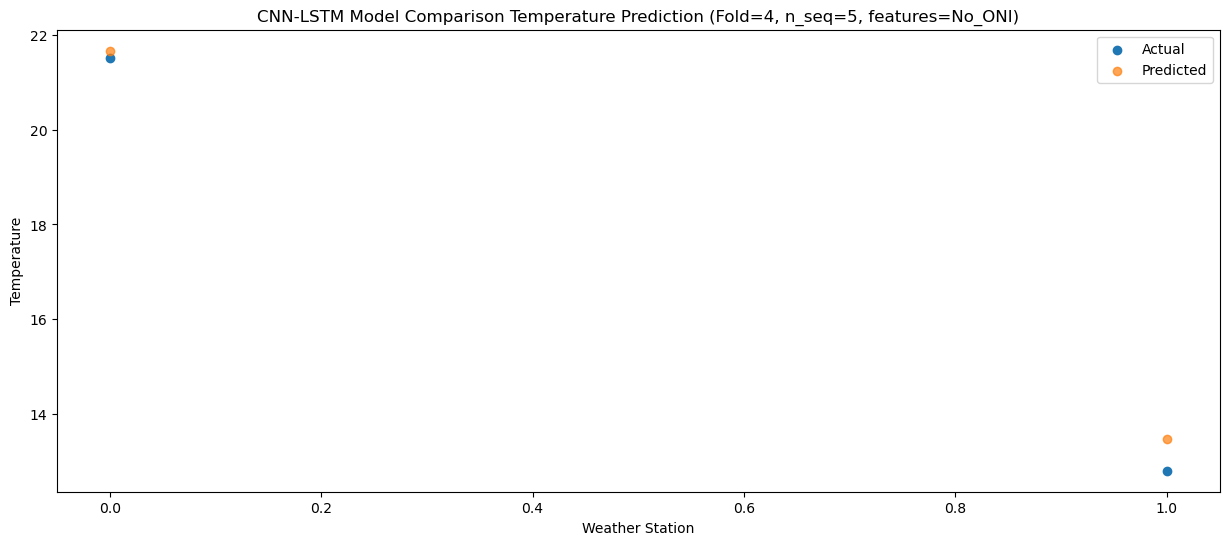

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.722074
1                1   13.11  13.512074


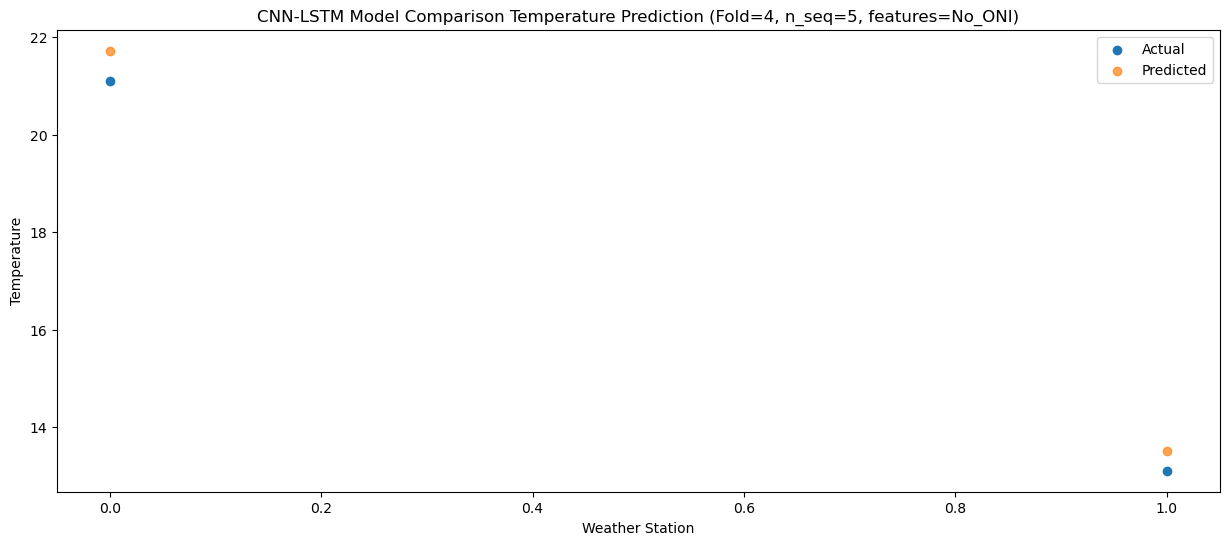

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  21.349679
1                1   12.24  13.139679


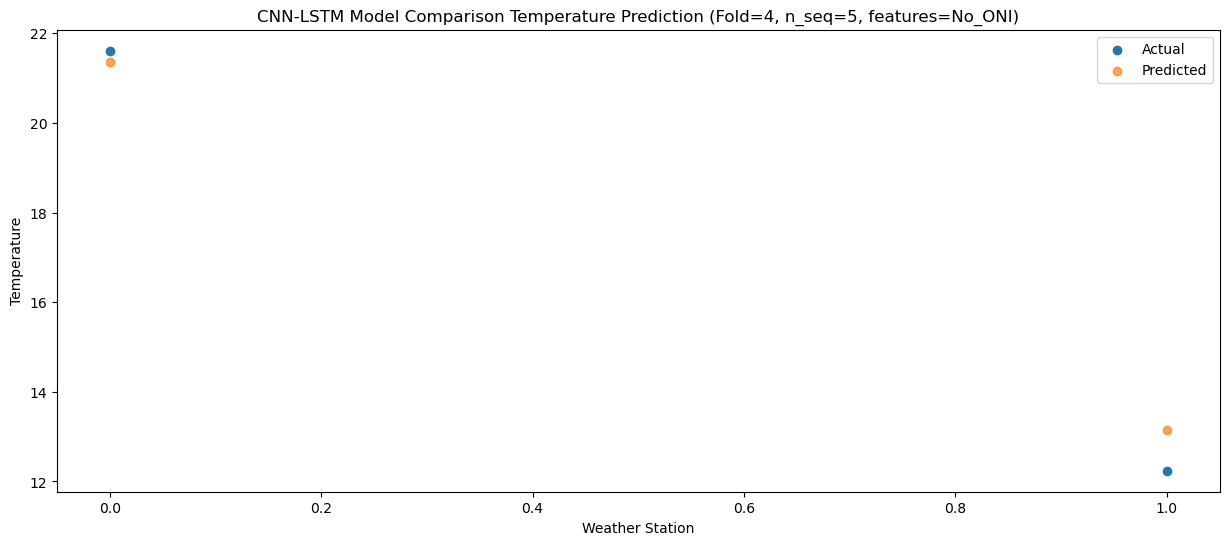

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  22.193032
1                1   13.72  13.983032


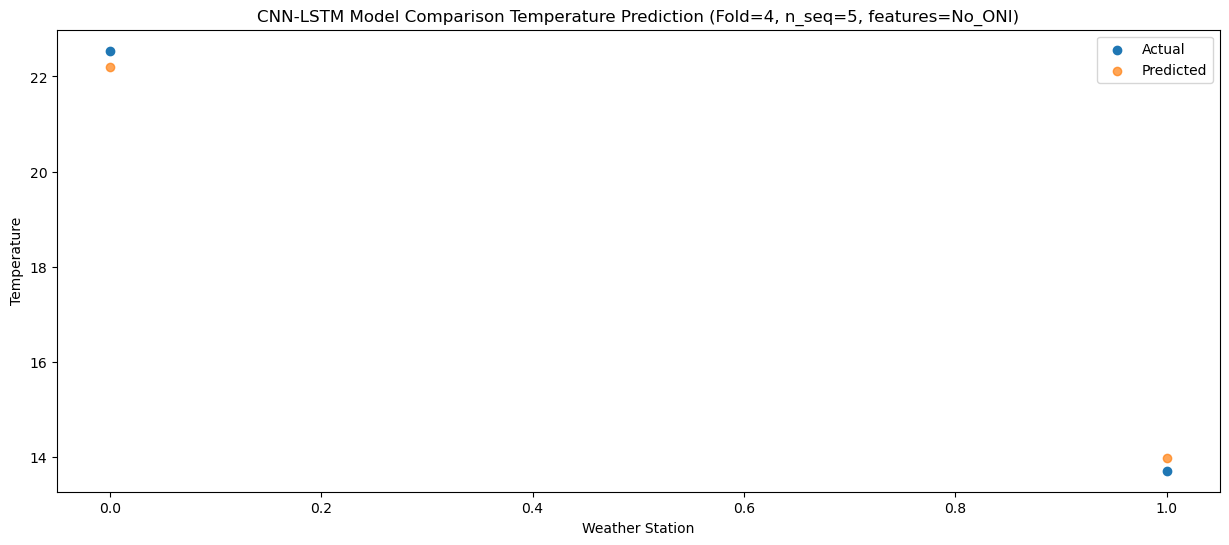

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[21.20548389 12.99548389]
 [21.67546321 13.46546321]
 [21.722074   13.512074  ]
 [21.34967864 13.13967864]
 [22.19303244 13.98303244]]
Year at t+1:
t+1 SKRMSE: 0.558650
t+1 KRMSE: 0.558650
t+1 MAE: 0.480484
t+1 SKMAPE: 0.035947
t+1 R2_SCORE: 0.983806
t+1 KMAPE: 0.035947
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.488575
t+2 KRMSE: 0.488575
t+2 MAE: 0.410463
t+2 SKMAPE: 0.029784
t+2 R2_SCORE: 0.987500
t+2 KMAPE: 0.029784
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.517831
t+3 KRMSE: 0.517831
t+3 MAE: 0.507074
t+3 SKMAPE: 0.029832
t+3 R2_SCORE: 0.983241
t+3 KMAPE: 0.029832
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.662265
t+4 KRMSE: 0.662265
t+4 MAE: 0.580000
t+4 SKMAPE: 0.042775
t+4 R2_SCORE: 0.980018
t+4 KMAPE: 0.042775
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.307874
t+5 KRMSE: 0.307874
t+5 MAE: 0.305000
t+5 SKMAPE: 0.017282
t+5 R2_SCORE: 0.995126
t+5 KMAPE: 0.017282
t+5 PEARSON: 1

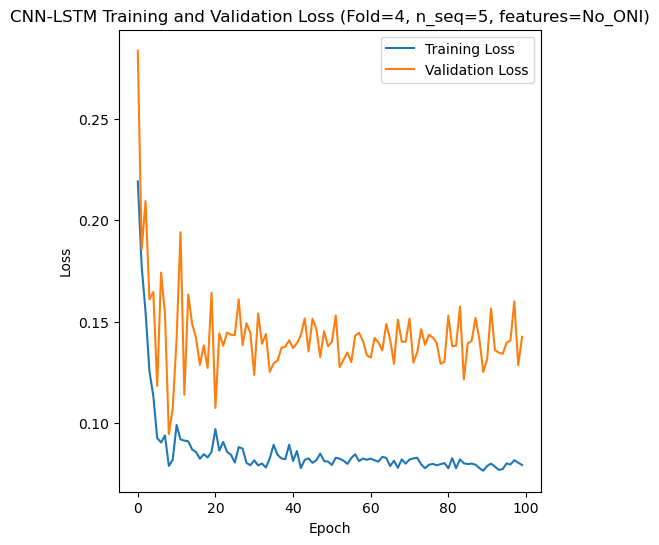

[[0.6588655241430109], [0.6264890471848086], [0.44590401800039825], [0.5839622683099059], [0.5200624118932473]]
[[array(0.65886552)], [array(0.62648905)], [array(0.44590402)], [array(0.58396227)], [array(0.52006241)]]
[[0.5311331037580974], [0.48192495837807703], [0.298887032032013], [0.4810177788436416], [0.4566042196750642]]
[[0.03001464841932914], [0.024197460485882234], [0.018813477539641944], [0.03329376091748927], [0.031124125598594548]]
[[0.9111765235304979], [0.013312435285159352], [0.9350528861544971], [-2.954953734571008], [0.9860660289937239]]
[[array(0.03001465)], [array(0.02419746)], [array(0.01881348)], [array(0.03329376)], [array(0.03112413)]]
[[array(0.92692454)], [array(0.10556032)], [array(0.94120765)], [array(0.27117246)], [array(0.99581254)]]
[20.77 20.94 20.77 21.01 21.43 17.52 16.69 16.18 16.46 16.29 19.62 19.71
 18.79 19.13 19.97 19.82 20.34 19.95 19.95 21.26 17.6  16.9  17.14 17.11
 17.55 13.84 13.83 13.82 13.36 14.15 14.42 14.47 14.79 14.78 14.49 14.47
 14.35 1

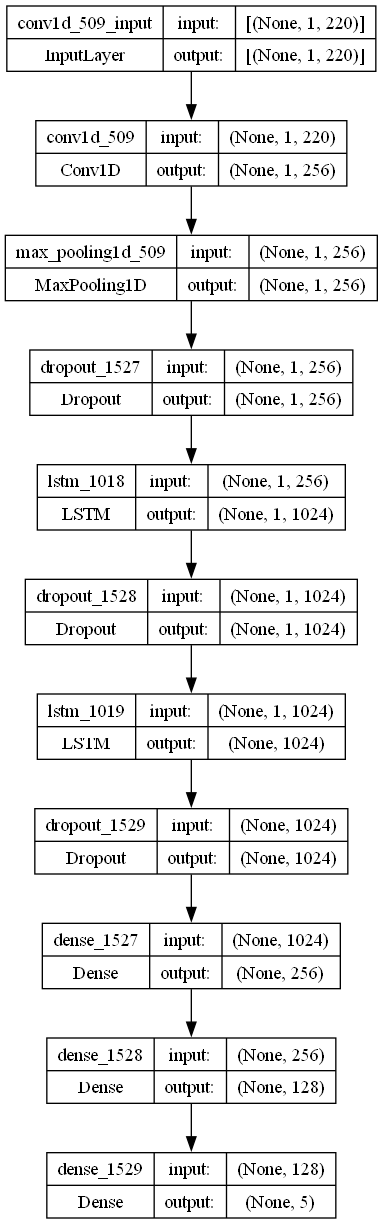

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0015483097407405432
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.20533022907051082

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S5_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)